# Import Libraries

In [315]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas_profiling import profile_report
import seaborn as sns
import pickle

%matplotlib inline

%load_ext autoreload
%autoreload 2

from src.utils import *

from collections import Counter
from collections import defaultdict
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc,confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from category_encoders.ordinal import OrdinalEncoder
from category_encoders.target_encoder import TargetEncoder
from sklearn.metrics import precision_recall_curve
import xgboost as xgb
import lightgbm as lgb
import shap

import warnings
warnings.filterwarnings("ignore")


pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Import data

In [13]:
main_folder='dataset'

## 2017

In [14]:
df_2017=import_data(main_folder,'2017')
df_2017.rename(columns={'trans_vat_desc':'trans_tax_desc'},inplace=True)
df_2017.head()

1 importando march-2017.xls
2 importando april-2017.xls
3 importando february-2017.xls
4 importando august-2017.xls
5 importando may-2017.xls
6 importando july-2017.xls
7 importando june-2017.xls
8 importando september-2017.xls
9 importando october-2017.xls
10 importando november-2017.xls
11 importando january-2017.xls
missing months ['december']


,trans_date,trans_tax_desc,original_gross_amt,original_cur,billing_gross_amt,billing_cur_code,merchant_name,card_number,trans_cac_code_1,trans_cac_desc_1,trans_cac_code_2,trans_cac_desc_2,trans_cac_code_3,directorate,trans_tax_amt,billing_cur_code_1
0,2017-03-21,VR,26.15,GBP,26.15,GBP,shell kings 587,************5770,K020,Vehicle Fuel,RV12N,African-Caribbean DC,A00,Adult & Communities,NaN,NaN
1,2017-03-23,VR,78.72,GBP,78.72,GBP,shell fiveways 387,************1147,K020,Vehicle Fuel,RV1K2,Elders Group - Ladywood,A00,Adult & Communities,NaN,NaN
2,2017-03-23,VR,68.00,GBP,68.00,GBP,shell fiveways 387,************1147,K020,Vehicle Fuel,RV1K2,Elders Group - Ladywood,A00,Adult & Communities,NaN,NaN
3,2017-03-21,VR,75.20,GBP,75.20,GBP,tesco pfs 4203,************1147,K020,Vehicle Fuel,RV1K2,Elders Group - Ladywood,A00,Adult & Communities,NaN,NaN
4,2017-03-17,VR,15.00,GBP,15.00,GBP,the gate fuels ltd,************1147,K020,Vehicle Fuel,RV1K2,Elders Group - Ladywood,A00,Adult & Communities,NaN,NaN


In [15]:
df_2017.info()

<class 'pandas.core.frame.DataFrame'>
Index: 48589 entries, 0 to 5226
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   trans_date          48589 non-null  datetime64[ns]
 1   trans_tax_desc      44331 non-null  object        
 2   original_gross_amt  48589 non-null  float64       
 3   original_cur        48589 non-null  object        
 4   billing_gross_amt   48589 non-null  float64       
 5   billing_cur_code    48589 non-null  object        
 6   merchant_name       48589 non-null  object        
 7   card_number         48589 non-null  object        
 8   trans_cac_code_1    48543 non-null  object        
 9   trans_cac_desc_1    48543 non-null  object        
 10  trans_cac_code_2    48500 non-null  object        
 11  trans_cac_desc_2    48500 non-null  object        
 12  trans_cac_code_3    48462 non-null  object        
 13  directorate         47851 non-null  object        
 

In [16]:
df_2017.isnull().sum()/df_2017.shape[0]

trans_date            0.000000
trans_tax_desc        0.087633
original_gross_amt    0.000000
original_cur          0.000000
billing_gross_amt     0.000000
billing_cur_code      0.000000
merchant_name         0.000000
card_number           0.000000
trans_cac_code_1      0.000947
trans_cac_desc_1      0.000947
trans_cac_code_2      0.001832
trans_cac_desc_2      0.001832
trans_cac_code_3      0.002614
directorate           0.015189
trans_tax_amt         0.905370
billing_cur_code_1    0.905370
dtype: float64

As `trans_tax_amt` and `billing_cur_code_1` has 90% of nulls we drop those columns

In [17]:
df_2017.drop(columns=['trans_tax_amt','billing_cur_code_1'],inplace=True)

## 2018

In [18]:
df_2018=import_data(main_folder,'2018')
df_2018.rename(columns={'trans_vat_desc':'trans_tax_desc'},inplace=True)
df_2018.head()

1 importando november-2018.xls
2 importando october-2018.xls
3 importando january-2018.xls
4 importando july-2018.xls
5 importando june-2018.xls
6 importando february-2018.xls
7 importando august-2018.xls
8 importando may-2018.xls
9 importando december-2018.xls
10 importando march-2018.xls
11 importando april-2018.xls
missing months ['september']


,trans_date,trans_tax_desc,original_gross_amt,original_cur,billing_gross_amt,billing_cur_code,trans_tax_rate,trans_tax_amt,merchant_name,card_number,trans_cac_code_1,trans_cac_desc_1,trans_cac_code_2,trans_cac_desc_2,trans_cac_code_3,directorate,trans_original_net_amt,billing_cur_code_1
0,2018-11-05,VR,65.00,GBP,65.00,GBP,20.0,10.83,vauxhall road fuel exp,************8738,K020,Vehicle Fuel,RV192,Sparkbrook Resource Centre,A00,Adult Social Care and Health,NaN,NaN
1,2018-11-05,VR,65.48,GBP,65.48,GBP,20.0,10.91,vauxhall road fuel exp,************8738,K020,Vehicle Fuel,RV192,Sparkbrook Resource Centre,A00,Adult Social Care and Health,NaN,NaN
2,2018-11-05,VR,34.57,GBP,34.57,GBP,20.0,5.76,vauxhall road fuel exp,************8738,K020,Vehicle Fuel,RV192,Sparkbrook Resource Centre,A00,Adult Social Care and Health,NaN,NaN
3,2018-11-22,VR,76.16,GBP,76.16,GBP,20.0,12.69,vauxhall road fuel exp,************8738,K020,Vehicle Fuel,RV192,Sparkbrook Resource Centre,A00,Adult Social Care and Health,NaN,NaN
4,2018-11-14,VR,69.00,GBP,69.00,GBP,20.0,11.50,shell kingbury roa,************5804,K020,Vehicle Fuel,RVA11,Beeches GOLDD,A00,Adult Social Care and Health,NaN,NaN


In [19]:
df_2018.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39704 entries, 0 to 2970
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   trans_date              39704 non-null  datetime64[ns]
 1   trans_tax_desc          38281 non-null  object        
 2   original_gross_amt      39704 non-null  float64       
 3   original_cur            39704 non-null  object        
 4   billing_gross_amt       21975 non-null  float64       
 5   billing_cur_code        39704 non-null  object        
 6   trans_tax_rate          16335 non-null  float64       
 7   trans_tax_amt           16335 non-null  float64       
 8   merchant_name           39704 non-null  object        
 9   card_number             39704 non-null  object        
 10  trans_cac_code_1        39658 non-null  object        
 11  trans_cac_desc_1        39658 non-null  object        
 12  trans_cac_code_2        39659 non-null  object      

## 2019

In [20]:
df_2019=import_data(main_folder,'2019')
df_2019['trans_tax_desc']=np.where(df_2019['trans_tax_desc'].isnull(),df_2019['trans_vat_desc'],df_2019['trans_tax_desc'])
df_2019.head()

1 importando january-2019.xls
2 importando november-2019.xls
3 importando october-2019.xls
4 importando september-2019.xls
5 importando june-2019.xls
6 importando july-2019.xls
7 importando may-2019.xls
8 importando august-2019.xls
9 importando february-2019.xls
10 importando december-2019.xls
11 importando march-2019.xls
12 importando april-2019.xls
missing months []


,trans_date,trans_vat_desc,original_gross_amt,original_cur,billing_gross_amt,billing_cur_code,trans_tax_rate,trans_tax_amt,merchant_name,card_number,trans_cac_code_1,trans_cac_desc_1,trans_cac_code_2,trans_cac_desc_2,trans_cac_code_3,directorate,trans_tax_desc,trans_original_net_amt,trans_post_date,mcc_code
0,2019-01-14,VR,76.26,GBP,76.26,GBP,20.0,12.71,vauxhall road fuel exp,************8738,K020,Vehicle Fuel,RV192,Sparkbrook Resource Centre,A00,Adult Social Care and Health,VR,NaN,NaT,NaN
1,2019-01-14,VR,76.12,GBP,76.12,GBP,20.0,12.69,vauxhall road fuel exp,************8738,K020,Vehicle Fuel,RV192,Sparkbrook Resource Centre,A00,Adult Social Care and Health,VR,NaN,NaT,NaN
2,2019-01-29,VR,74.09,GBP,74.09,GBP,20.0,12.35,vauxhall road fuel exp,************8738,K020,Vehicle Fuel,RV192,Sparkbrook Resource Centre,A00,Adult Social Care and Health,VR,NaN,NaT,NaN
3,2019-01-22,VR,84.79,GBP,84.79,GBP,20.0,14.13,vauxhall road fuel exp,************8738,K020,Vehicle Fuel,RV192,Sparkbrook Resource Centre,A00,Adult Social Care and Health,VR,NaN,NaT,NaN
4,2019-01-18,VR,69.50,GBP,69.50,GBP,20.0,11.58,vauxhall road fuel exp,************8738,K020,Vehicle Fuel,RV192,Sparkbrook Resource Centre,A00,Adult Social Care and Health,VR,NaN,NaT,NaN


In [21]:
df_2019.info()

<class 'pandas.core.frame.DataFrame'>
Index: 43673 entries, 0 to 2848
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   trans_date              43673 non-null  datetime64[ns]
 1   trans_vat_desc          13563 non-null  object        
 2   original_gross_amt      43673 non-null  float64       
 3   original_cur            43673 non-null  object        
 4   billing_gross_amt       43673 non-null  float64       
 5   billing_cur_code        43673 non-null  object        
 6   trans_tax_rate          31295 non-null  float64       
 7   trans_tax_amt           31295 non-null  float64       
 8   merchant_name           43673 non-null  object        
 9   card_number             43673 non-null  object        
 10  trans_cac_code_1        43606 non-null  object        
 11  trans_cac_desc_1        43606 non-null  object        
 12  trans_cac_code_2        43613 non-null  object      

## 2020

In [22]:
df_2020=import_data(main_folder,'2020')
df_2020.head()

1 importando january-2020.xls
2 importando october-2020.xls
3 importando november-2020.xls
4 importando june-2020.xls
5 importando july-2020.xls
6 importando september-2020.xls
7 importando december-2020.xls
8 importando may-2020.xls
9 importando august-2020.xls
10 importando february-2020.xls
11 importando april-2020.xls
12 importando march-2020.xls
missing months []


,trans_date,trans_tax_desc,original_gross_amt,original_cur,billing_gross_amt,billing_cur_code,trans_tax_rate,trans_tax_amt,trans_original_net_amt,card_number,trans_cac_code_1,trans_cac_desc_1,trans_cac_code_2,trans_cac_desc_2,trans_cac_code_3,directorate,merchant_name,billing_cur_code_1,trans_cac_desc_3,trans_cac_code_4,trans_cac_desc_4,trans_cac_code_5,trans_cac_desc_5,trans_cac_code_6,trans_cac_desc_6,trans_cac_code_7,trans_cac_desc_7,trans_cac_code_8,trans_cac_desc_8,trans_cac_code_9,trans_cac_desc_9,trans_cac_code_10,trans_cac_desc_10,trans_cac_code_11,trans_cac_desc_11,trans_cac_code_12,trans_cac_desc_12,trans_account_key,trans_account_key_desc,claim_no,claim_name,trans_expense_category,split_expense_category,split_unit_cost,split_quantity,merchant_tax_reg_no
0,2020-01-07,VR,79.52,GBP,79.52,GBP,20.0,13.25,66.27,************6208,K020,Vehicle Fuel,RV192,Sparkbrook Resource Centre,A00,ADULT SOCIAL CARE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-01-10,VR,70.26,GBP,70.26,GBP,20.0,11.71,58.55,************6208,K020,Vehicle Fuel,RV192,Sparkbrook Resource Centre,A00,ADULT SOCIAL CARE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-01-14,VR,66.03,GBP,66.03,GBP,20.0,11.01,55.02,************6208,K020,Vehicle Fuel,RV192,Sparkbrook Resource Centre,A00,ADULT SOCIAL CARE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-01-14,VR,41.77,GBP,41.77,GBP,20.0,6.96,34.81,************6208,K020,Vehicle Fuel,RV192,Sparkbrook Resource Centre,A00,ADULT SOCIAL CARE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-01-20,VR,60.01,GBP,60.01,GBP,20.0,10.00,50.01,************6208,K020,Vehicle Fuel,RV192,Sparkbrook Resource Centre,A00,ADULT SOCIAL CARE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
df_2020.info()

<class 'pandas.core.frame.DataFrame'>
Index: 38387 entries, 0 to 2949
Data columns (total 46 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   trans_date              38386 non-null  datetime64[ns]
 1   trans_tax_desc          37480 non-null  object        
 2   original_gross_amt      38386 non-null  float64       
 3   original_cur            38386 non-null  object        
 4   billing_gross_amt       34512 non-null  float64       
 5   billing_cur_code        38386 non-null  object        
 6   trans_tax_rate          5633 non-null   float64       
 7   trans_tax_amt           10317 non-null  float64       
 8   trans_original_net_amt  7024 non-null   float64       
 9   card_number             38386 non-null  object        
 10  trans_cac_code_1        38327 non-null  object        
 11  trans_cac_desc_1        38327 non-null  object        
 12  trans_cac_code_2        37892 non-null  object      

## 2021

In [24]:
df_2021=import_data(main_folder,'2021')
df_2021.head()

1 importando october-2021.xls
2 importando november-2021.xls
3 importando january-2021.xls
4 importando july-2021.xls
5 importando june-2021.xls
6 importando september-2021.xls
7 importando december-2021.xls
8 importando february-2021.xls
9 importando august-2021.xls
10 importando may-2021.xls
11 importando april-2021.xls
12 importando march-2021.xls
missing months []


,trans_date,trans_tax_desc,original_gross_amt,original_cur,billing_gross_amt,billing_cur_code,trans_tax_rate,trans_tax_amt,trans_original_net_amt,merchant_name,card_number,trans_cac_code_1,trans_cac_desc_1,trans_cac_code_2,trans_cac_desc_2,trans_cac_code_3,directorate,trans_cac_desc_3,merchant_tax_reg_no,mcc_code
0,2021-10-04,VF,54.59,GBP,54.59,GBP,12.5,6.07,48.52,costco pfs,************6208,K020,Vehicle Fuel,RV192,Sparkbrook Resource Centre,A00,ADULT SOCIAL CARE,NaN,NaN,NaN
1,2021-10-20,VF,61.01,GBP,61.01,GBP,12.5,6.78,54.23,costco pfs,************6208,K020,Vehicle Fuel,RV192,Sparkbrook Resource Centre,A00,ADULT SOCIAL CARE,NaN,NaN,NaN
2,2021-10-07,VF,55.11,GBP,55.11,GBP,12.5,6.12,48.99,costco pfs,************8738,K020,Vehicle Fuel,RV192,Sparkbrook Resource Centre,A00,ADULT SOCIAL CARE,NaN,NaN,NaN
3,2021-10-14,VF,90.50,GBP,90.50,GBP,12.5,10.06,80.44,vauxhall road fuel exp,************8738,K020,Vehicle Fuel,RV192,Sparkbrook Resource Centre,A00,ADULT SOCIAL CARE,NaN,NaN,NaN
4,2021-11-01,VF,76.06,GBP,76.06,GBP,12.5,8.45,67.61,costco pfs,************3469,K020,Vehicle Fuel,RV192,Sparkbrook Resource Centre,A00,ADULT SOCIAL CARE,NaN,NaN,NaN


In [25]:
df_2021.info()

<class 'pandas.core.frame.DataFrame'>
Index: 41640 entries, 0 to 1811
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   trans_date              41640 non-null  datetime64[ns]
 1   trans_tax_desc          40989 non-null  object        
 2   original_gross_amt      41640 non-null  float64       
 3   original_cur            41640 non-null  object        
 4   billing_gross_amt       39573 non-null  float64       
 5   billing_cur_code        41640 non-null  object        
 6   trans_tax_rate          20217 non-null  float64       
 7   trans_tax_amt           24187 non-null  float64       
 8   trans_original_net_amt  21820 non-null  float64       
 9   merchant_name           41639 non-null  object        
 10  card_number             41640 non-null  object        
 11  trans_cac_code_1        41459 non-null  object        
 12  trans_cac_desc_1        41459 non-null  object      

## 2022

In [26]:
df_2022=import_data(main_folder,'2022')
df_2022.head()

1 importando november-2022.xls
2 importando october-2022.xls
3 importando january-2022.xls
4 importando july-2022.xls
5 importando june-2022.xls
6 importando september-2022.xls
7 importando december-2022.xls
8 importando february-2022.xls
9 importando august-2022.xls
10 importando may-2022.xls
11 importando march-2022.xls
12 importando april-2022.xls
missing months []


,trans_date,trans_tax_desc,original_gross_amt,original_cur,billing_cur_code,billing_gross_amt,trans_tax_rate,trans_tax_amt,trans_original_net_amt,merchant_name,card_number,trans_cac_code_1,trans_cac_code_2,trans_cac_code_3,trans_cac_code_4,trans_cac_code_5,trans_cac_code_6,trans_cac_code_7,trans_cac_code_8,directorate,trans_cac_desc_1,trans_cac_desc_2,trans_cac_desc_3,trans_cac_code_9,trans_cac_desc_9,trans_cac_code_10,trans_cac_desc_10,trans_cac_code_11,trans_cac_desc_11,trans_cac_code_12,trans_cac_desc_12,trans_account_key,trans_account_key_desc,claim_no,claim_name,trans_expense_category,split_expense_category,split_unit_cost,split_quantity,trans_cac_desc_4,trans_cac_desc_5,trans_cac_desc_6,trans_cac_desc_7,trans_cac_desc_8
0,2022-11-07,VR,96.09,GBP,GBP,96.09,20.0,16.02,80.07,vauxhall road fuel exp,************6208,B1,AV0AR,3A01,E00,JZZZZZ,TV01V,JZZZ,JXXX,ADULT SOCIAL CARE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-11-11,VR,100.00,GBP,GBP,100.00,20.0,16.67,83.33,vauxhall road fuel exp,************6208,B1,AV0AR,3A01,E00,JZZZZZ,TV01V,JZZZ,JXXX,ADULT SOCIAL CARE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2022-11-17,VR,94.57,GBP,GBP,94.57,20.0,15.76,78.81,meridian service s,************6208,B1,AV0AR,3A01,E00,JZZZZZ,TV01V,JZZZ,JXXX,ADULT SOCIAL CARE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2022-11-24,VZ,100.00,GBP,GBP,100.00,0.0,0.00,100.00,revolut5782,************0065,B1,AV0AN,NaN,E00,JZZZZZ,TZZZZ,JZZZ,JXXX,ADULT SOCIAL CARE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2022-11-24,VZ,100.00,GBP,GBP,100.00,0.0,0.00,100.00,revolut0553,************0065,B1,AV0AN,NaN,E00,JZZZZZ,TZZZZ,JZZZ,JXXX,ADULT SOCIAL CARE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
df_2022.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49565 entries, 0 to 2921
Data columns (total 44 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   trans_date              49565 non-null  datetime64[ns]
 1   trans_tax_desc          48949 non-null  object        
 2   original_gross_amt      49565 non-null  float64       
 3   original_cur            49565 non-null  object        
 4   billing_cur_code        49565 non-null  object        
 5   billing_gross_amt       49565 non-null  float64       
 6   trans_tax_rate          22667 non-null  float64       
 7   trans_tax_amt           45041 non-null  float64       
 8   trans_original_net_amt  40957 non-null  float64       
 9   merchant_name           49565 non-null  object        
 10  card_number             49565 non-null  object        
 11  trans_cac_code_1        49520 non-null  object        
 12  trans_cac_code_2        49089 non-null  object      

## 2023

In [28]:
df_2023=import_data(main_folder,'2023')
df_2023.head()

1 importando january-2023.xls
2 importando june-2023.xls
3 importando july-2023.xls
4 importando may-2023.xls
5 importando february-2023.xls
6 importando march-2023.xls
7 importando april-2023.xls
missing months ['august', 'september', 'october', 'november', 'december']


,trans_date,trans_tax_desc,original_gross_amt,original_cur,billing_cur_code,billing_gross_amt,trans_tax_rate,trans_tax_amt,trans_original_net_amt,merchant_name,card_number,trans_cac_code_1,trans_cac_code_2,trans_cac_code_3,trans_cac_code_4,trans_cac_code_5,trans_cac_code_6,trans_cac_code_7,trans_cac_code_8,directorate,billing_cur_code_1
0,2023-01-09,VR,82.91,GBP,GBP,82.91,20.0,13.82,69.09,vauxhall road fuel exp,************6208,B1,AV0AR,3A01,E00,JZZZZZ,TV01V,JZZZ,JXXX,ADULT SOCIAL CARE,NaN
1,2023-01-17,VR,100.00,GBP,GBP,100.00,20.0,16.67,83.33,vauxhall road fuel exp,************6208,B1,AV0AR,3A01,E00,JZZZZZ,TV01V,JZZZ,JXXX,ADULT SOCIAL CARE,NaN
2,2023-01-24,VR,94.32,GBP,GBP,94.32,20.0,15.72,78.60,vauxhall road fuel exp,************6208,B1,AV0AR,3A01,E00,JZZZZZ,TV01V,JZZZ,JXXX,ADULT SOCIAL CARE,NaN
3,2023-01-26,VR,98.55,GBP,GBP,98.55,20.0,16.43,82.12,vauxhall road fuel exp,************6208,B1,AV0AR,3A01,E00,JZZZZZ,TV01V,JZZZ,JXXX,ADULT SOCIAL CARE,NaN
4,2023-01-30,VR,65.59,GBP,GBP,65.59,20.0,0.00,65.59,vauxhall road fuel exp,************6208,B1,AV0AR,NaN,E00,JZZZZZ,TV01V,JZZZ,JXXX,ADULT SOCIAL CARE,NaN


In [29]:
df_2023.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29617 entries, 0 to 3298
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   trans_date              29617 non-null  datetime64[ns]
 1   trans_tax_desc          29307 non-null  object        
 2   original_gross_amt      29617 non-null  float64       
 3   original_cur            29617 non-null  object        
 4   billing_cur_code        25227 non-null  object        
 5   billing_gross_amt       29617 non-null  float64       
 6   trans_tax_rate          9412 non-null   float64       
 7   trans_tax_amt           29617 non-null  float64       
 8   trans_original_net_amt  25569 non-null  float64       
 9   merchant_name           29617 non-null  object        
 10  card_number             29617 non-null  object        
 11  trans_cac_code_1        29601 non-null  object        
 12  trans_cac_code_2        29574 non-null  object      

## concat all years

As 2017 has the less number of columns, we are going to have as reference the 2017 columns

In [30]:
reference_col=df_2017.columns

In [31]:
list_df=[df_2017,df_2018,df_2019,df_2020,df_2021,df_2022,df_2023]

We keep the columns that appear in all years

In [32]:
for one_df in list_df:
    if len(reference_col.intersection(one_df.columns))<len(reference_col):
        reference_col=reference_col.intersection(one_df.columns)
    else:
        pass

In [33]:
final_list_df=[df_year[reference_col] for df_year in list_df]
df=pd.concat(final_list_df)
df.head()

,trans_date,trans_tax_desc,original_gross_amt,original_cur,billing_gross_amt,billing_cur_code,merchant_name,card_number,trans_cac_code_1,trans_cac_code_2,trans_cac_code_3,directorate
0,2017-03-21,VR,26.15,GBP,26.15,GBP,shell kings 587,************5770,K020,RV12N,A00,Adult & Communities
1,2017-03-23,VR,78.72,GBP,78.72,GBP,shell fiveways 387,************1147,K020,RV1K2,A00,Adult & Communities
2,2017-03-23,VR,68.00,GBP,68.00,GBP,shell fiveways 387,************1147,K020,RV1K2,A00,Adult & Communities
3,2017-03-21,VR,75.20,GBP,75.20,GBP,tesco pfs 4203,************1147,K020,RV1K2,A00,Adult & Communities
4,2017-03-17,VR,15.00,GBP,15.00,GBP,the gate fuels ltd,************1147,K020,RV1K2,A00,Adult & Communities


Create column which refers to month of transaction

In [84]:
df['periodo']=df['trans_date'].dt.strftime('%Y-%m-01')
df['periodo'] = pd.to_datetime(df['periodo'])
df['next_periodo'] = df['periodo'].apply(lambda x: x + pd.DateOffset(months=1))
df.head()

# auxiliar table to define inactivity of cards
temp=df.groupby(['periodo','card_number'],as_index=False)['trans_date'].count()
temp['periodo'] = pd.to_datetime(temp['periodo'])
temp['flag_inactivity']=0

df_final=df.merge(temp.drop(columns=['trans_date']),how='left',left_on=['next_periodo','card_number'],right_on=['periodo','card_number'])
df_final['flag_inactivity']=df_final['flag_inactivity'].fillna(1)
df_final.drop(columns=['next_periodo','periodo_y'],inplace=True)
df_final.rename(columns={'periodo_x':'periodo'},inplace=True)

df_final.head()


,trans_date,trans_tax_desc,original_gross_amt,original_cur,billing_gross_amt,billing_cur_code,merchant_name,card_number,trans_cac_code_1,trans_cac_code_2,trans_cac_code_3,directorate,periodo,flag_inactivity
0,2017-03-21,VR,26.15,GBP,26.15,GBP,shell kings 587,************5770,K020,RV12N,A00,Adult & Communities,2017-03-01,0.0
1,2017-03-23,VR,78.72,GBP,78.72,GBP,shell fiveways 387,************1147,K020,RV1K2,A00,Adult & Communities,2017-03-01,0.0
2,2017-03-23,VR,68.00,GBP,68.00,GBP,shell fiveways 387,************1147,K020,RV1K2,A00,Adult & Communities,2017-03-01,0.0
3,2017-03-21,VR,75.20,GBP,75.20,GBP,tesco pfs 4203,************1147,K020,RV1K2,A00,Adult & Communities,2017-03-01,0.0
4,2017-03-17,VR,15.00,GBP,15.00,GBP,the gate fuels ltd,************1147,K020,RV1K2,A00,Adult & Communities,2017-03-01,0.0


# EDA

In [85]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 291175 entries, 0 to 291174
Data columns (total 14 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   trans_date          291174 non-null  datetime64[ns]
 1   trans_tax_desc      282168 non-null  object        
 2   original_gross_amt  291174 non-null  float64       
 3   original_cur        291174 non-null  object        
 4   billing_gross_amt   267504 non-null  float64       
 5   billing_cur_code    286784 non-null  object        
 6   merchant_name       286842 non-null  object        
 7   card_number         291174 non-null  object        
 8   trans_cac_code_1    290714 non-null  object        
 9   trans_cac_code_2    289638 non-null  object        
 10  trans_cac_code_3    270330 non-null  object        
 11  directorate         290436 non-null  object        
 12  periodo             291174 non-null  datetime64[ns]
 13  flag_inactivity     291175 no

In [92]:
df_final.groupby(['periodo'],as_index=False)['card_number'].count()

,periodo,card_number
0,2016-12-01,4
1,2017-01-01,4819
2,2017-02-01,3927
3,2017-03-01,4532
4,2017-04-01,2986
5,2017-05-01,5354
6,2017-06-01,5004
7,2017-07-01,5044
8,2017-08-01,2474
9,2017-09-01,4401


In [86]:
profile=df_final.profile_report(
        title='Pandas profiling Report',
        correlations={'spearman':{'calculate':True},
        'pearson':{'calculate':True}},
        interactions={'targets':['flag_inactivity'],'continuous':True}
        #,minimal=True
        ,explorative=True
        )

In [87]:
profile.to_file('inactivity_card_profiling.html')

Summarize dataset:  65%|██████▌   | 15/23 [00:02<00:01,  6.49it/s, Calculate spearman correlation]      /opt/homebrew/lib/python3.10/site-packages/pandas_profiling/model/correlations.py:67: UserWarning: There was an attempt to calculate the spearman correlation, but this failed.
To hide this warning, disable the calculation
(using `df.profile_report(correlations={"spearman": {"calculate": False}})`
If this is problematic for your use case, please report this as an issue:
https://github.com/ydataai/pandas-profiling/issues
(include the error message: 'could not convert string to float: 'VR'')
  warnings.warn(
Summarize dataset:  70%|██████▉   | 16/23 [00:02<00:01,  6.49it/s, Calculate pearson correlation] /opt/homebrew/lib/python3.10/site-packages/pandas_profiling/model/correlations.py:67: UserWarning: There was an attempt to calculate the pearson correlation, but this failed.
To hide this warning, disable the calculation
(using `df.profile_report(correlations={"pearson": {"calculate": F

# Feature engineering

According to the report, I conclude the following:<br>
- Drop `billing_cur_code` because it only has 1 value
- Drop duplicate rows
- Category columns which has high cardinality, reduce the number of categories - Encode category columns(this step will be done once the final table is ready)
- Delete high correlation between `original_gross_amt` and `billing_gross_amt`
- Drop rows outliers

In [101]:
df_final.drop(columns='billing_cur_code',inplace=True)

In [102]:
df_final.drop_duplicates(inplace=True)

In [103]:
df_final[['original_gross_amt','billing_gross_amt']].corr()

,original_gross_amt,billing_gross_amt
original_gross_amt,1.000000,0.642666
billing_gross_amt,0.642666,1.000000


Having seen correlation between both columns, I keep column with less number of nulls which is `original_gross_amt`, but i create a column with a flag of nulls of the deleted column

In [104]:
df_final['flag_nan_bill_amt']=np.where(df_final['billing_gross_amt'].isnull(),1,0)
df_final.drop(columns='billing_gross_amt',inplace=True)

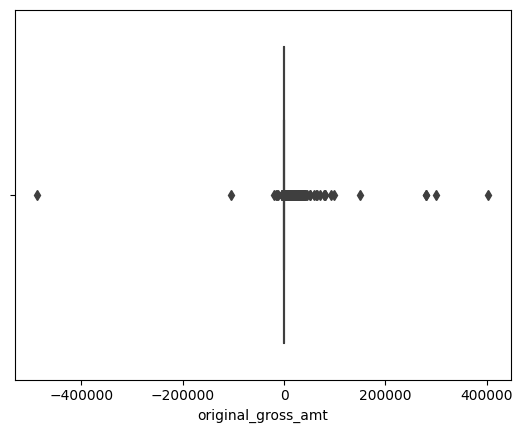

In [105]:
sns.boxplot(data=df_final, x='original_gross_amt')
plt.show()

In [106]:
Q1 = df_final['original_gross_amt'].quantile(0.25)
Q3 = df_final['original_gross_amt'].quantile(0.75)
IQR = Q3 - Q1

df_final_v2 = df_final[(df_final['original_gross_amt'] >= Q1 - 1.5 * IQR) & (df_final['original_gross_amt'] <= Q3 + 1.5 * IQR)]

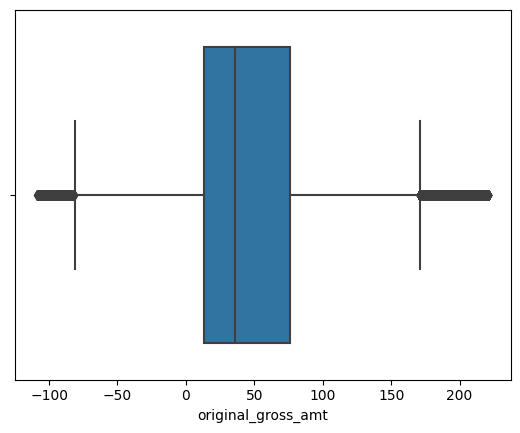

In [107]:
sns.boxplot(data=df_final_v2, x='original_gross_amt')
plt.show()

Let's create some columns related to the date of transaction

In [109]:
df_final_v2['trans_date_weekday']=df_final_v2['trans_date'].dt.weekday
df_final_v2['trans_date_day']=df_final_v2['trans_date'].dt.day
df_final_v2['trans_date_wom']=np.where((df_final_v2['trans_date_day']>=1)&(df_final_v2['trans_date_day']<=7),0,1)
df_final_v2['trans_date_wom']=np.where((df_final_v2['trans_date_day']>=8)&(df_final_v2['trans_date_day']<=14),1,df_final_v2['trans_date_wom'])
df_final_v2['trans_date_wom']=np.where((df_final_v2['trans_date_day']>=15)&(df_final_v2['trans_date_day']<=21),2,df_final_v2['trans_date_wom'])
df_final_v2['trans_date_wom']=np.where((df_final_v2['trans_date_day']>=22)&(df_final_v2['trans_date_day']<=28),3,df_final_v2['trans_date_wom'])
df_final_v2['trans_date_wom']=np.where((df_final_v2['trans_date_day']>=29),4,df_final_v2['trans_date_wom'])

/var/folders/tk/x3_nwj8533d75chf2_40wmy80000gn/T/ipykernel_59987/4010338071.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final_v2['trans_date_weekday']=df_final_v2['trans_date'].dt.weekday
/var/folders/tk/x3_nwj8533d75chf2_40wmy80000gn/T/ipykernel_59987/4010338071.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final_v2['trans_date_day']=df_final_v2['trans_date'].dt.day
/var/folders/tk/x3_nwj8533d75chf2_40wmy80000gn/T/ipykernel_59987/4010338071.py:3: SettingWithCopyWarning: 
A value is tryi

In [128]:
# Sort the DataFrame by 'card_number', 'periodo', and 'trans_date'
df_final_v2 = df_final_v2.sort_values(by=['card_number', 'periodo', 'trans_date'])

# Create a new column 'prev_trans_date' to store the previous transaction date within each group
df_final_v2['prev_trans_date'] = df_final_v2.groupby(['card_number', 'periodo'])['trans_date'].shift(1)

# Calculate the difference in days and fill NaN values with 0
df_final_v2['diff_trans'] = (df_final_v2['trans_date'] - df_final_v2['prev_trans_date']).dt.days.fillna(0)

# Drop the 'prev_trans_date' column if you no longer need it
df_final_v2 = df_final_v2.drop(columns=['prev_trans_date'])

df_final_v2.head()

,trans_date,trans_tax_desc,original_gross_amt,original_cur,merchant_name,card_number,trans_cac_code_1,trans_cac_code_2,trans_cac_code_3,directorate,periodo,flag_inactivity,flag_nan_bill_amt,trans_date_weekday,trans_date_day,trans_date_wom,diff_trans
0,2022-10-04,VR,1.50,GBP,card factory,************0012,T1,BV06H,4D01,Birmingham Childrens Trust,2022-10-01,0.0,0,1,4,0,0.0
1,2022-10-04,VR,22.25,GBP,poundland 1509,************0012,T1,BV06H,4A0C,Birmingham Childrens Trust,2022-10-01,0.0,0,1,4,0,0.0
2,2022-10-04,VR,14.13,GBP,aldi 9 772,************0012,T1,BV06H,4B00,Birmingham Childrens Trust,2022-10-01,0.0,0,1,4,0,0.0
3,2022-10-05,VR,6.39,GBP,amznmktplace,************0012,T1,BV06H,4A0C,Birmingham Childrens Trust,2022-10-01,0.0,0,2,5,0,1.0
4,2022-10-15,VR,13.00,GBP,disclosure barring,************0012,T1,BV06H,1G07,Birmingham Childrens Trust,2022-10-01,0.0,0,5,15,2,10.0


So, the target of this model is to predict inactivity of the card the following month: That means that if in one month the card do many transaction and the following month it doesn't do any one, then the target is flagged as 1. <br>

For that reason, I am going to work with a summary of transactions by card and period.

In [133]:
df_final_v3=df_final_v2.groupby(['card_number','periodo'],as_index=False).agg(
    {
        'trans_tax_desc':mode_string,
        'original_gross_amt':['sum','mean','min','max'],
        'original_cur':mode_string,
        'merchant_name':mode_string,
        'trans_cac_code_1':mode_string,
        'trans_cac_code_2':mode_string,
        'trans_cac_code_3':mode_string,
        'directorate': mode_string,
        'flag_inactivity':'max',
        'flag_nan_bill_amt':'max',
        'trans_date_weekday':mode_string,
        'trans_date_day': mode_string,
        'trans_date_wom': mode_string,
        'diff_trans':['mean','max']
    }
)

# Join the multi-level column names into a single level
df_final_v3.columns = df_final_v3.columns.map('_'.join)

df_final_v3.rename(columns={'card_number_':'card_number','periodo_':'periodo'},inplace=True)

df_final_v3.head()

,card_number,periodo,trans_tax_desc_mode_string,original_gross_amt_sum,original_gross_amt_mean,original_gross_amt_min,original_gross_amt_max,original_cur_mode_string,merchant_name_mode_string,trans_cac_code_1_mode_string,trans_cac_code_2_mode_string,trans_cac_code_3_mode_string,directorate_mode_string,flag_inactivity_max,flag_nan_bill_amt_max,trans_date_weekday_mode_string,trans_date_day_mode_string,trans_date_wom_mode_string,diff_trans_mean,diff_trans_max
0,************0012,2022-10-01,VR,322.91,32.291000,1.50,100.98,GBP,amznmktplace,T1,BV06H,4A0C,Birmingham Childrens Trust,0.0,0,1,4,0,2.300000,10.0
1,************0012,2022-11-01,VR,58.68,29.340000,13.68,45.00,GBP,aldi 9 772,B1,BV06H,4A0C,Birmingham Childrens Trust,1.0,0,1,1,0,3.500000,7.0
2,************0025,2017-05-01,VZ,195.54,48.885000,20.97,95.99,GBP,waterstones.com,L030,REACR,A00,CYP&F SCHOOLS,0.0,0,0,14,2,2.000000,4.0
3,************0025,2017-06-01,VR,368.85,73.770000,14.98,149.99,GBP,post office shop,L100,REACR,A00,CYP&F SCHOOLS,0.0,0,0,19,2,0.600000,2.0
4,************0025,2017-07-01,VZ,626.00,48.153846,-13.02,179.99,GBP,amazon uk marketplace,L030,REACR,A00,CYP&F SCHOOLS,0.0,0,0,24,3,1.923077,7.0


In [143]:
df_final_v3.isnull().sum()

card_number                          0
periodo                              0
trans_tax_desc_mode_string         123
original_gross_amt_sum               0
original_gross_amt_mean              0
original_gross_amt_min               0
original_gross_amt_max               0
original_cur_mode_string             0
merchant_name_mode_string          524
trans_cac_code_1_mode_string        16
trans_cac_code_2_mode_string       202
trans_cac_code_3_mode_string      2556
directorate_mode_string             76
flag_inactivity_max                  0
flag_nan_bill_amt_max                0
trans_date_weekday_mode_string       0
trans_date_day_mode_string           0
trans_date_wom_mode_string           0
diff_trans_mean                      0
diff_trans_max                       0
dtype: int64

In [221]:
category_columns=df_final_v3.drop(columns='card_number').select_dtypes(include=['object']).columns

threshold_category=400

for col in category_columns:
    prueba_serie=df_final_v3[col].value_counts()
    prueba_serie.to_json('outputs/category/'+col+'_series.json')
    df_final_v3[col]=np.where(df_final_v3[col].isin(list(prueba_serie[prueba_serie<threshold_category].index)),'Otros',df_final_v3[col])
    try:
        df_final_v3[col]=df_final_v3[col].fillna('Otros')
    except:
        pass

# Train and test

We are going to use to train and validate months from *2020-06-01* (because of covid situation) until *2023-04-01* and to test we are using *2023-05-01* and *2023-06-01* <br>
- train periods: 2020-06-01 to 2023-04-01
- test periodos: 2023-05-01 and 2023-06-01

In [317]:
max_periodo_train='2020-06-01'
min_periodo_train='2022-12-01'
periodos_test=['2023-05-01','2023-06-01','2023-04-01','2023-03-01','2023-02-01','2023-01-01']

df_train=df_final_v3[(df_final_v3['periodo']>=max_periodo_train)&(df_final_v3['periodo']<=min_periodo_train)].copy()
df_test=df_final_v3[df_final_v3['periodo'].isin(periodos_test)].copy()

In [223]:
column_names=['Model','Encoding','Balancing','AUC','F1_score','Precision','Recall','threshold','flag_cv']
metrics = pd.DataFrame(columns = column_names)

In [224]:
categoricals_to_index=list(category_columns)+['flag_nan_bill_amt_max','trans_date_weekday_mode_string','trans_date_day_mode_string','trans_date_wom_mode_string']
columns_to_train=list(df_train.drop(columns=['card_number','periodo','flag_inactivity_max']).columns)

y='flag_inactivity_max'
id='card_number'

## Train

### logistic regression

In [225]:
X_train, X_test, y_train, y_test = train_test_split(df_train[columns_to_train], df_train[y], 
                                                    test_size=0.3, random_state=42,
                                                    stratify=df_train[y])

In [226]:
encoder = TargetEncoder(cols=categoricals_to_index)
encoder.fit(X_train, y_train)
with open("outputs/encoders/target_encoder.pkl", "wb") as f:
    pickle.dump(encoder, f)
X_train = encoder.transform(X_train)
X_test = encoder.transform(X_test)

In [227]:
scaler = StandardScaler()
X_train[columns_to_train]=scaler.fit_transform(X_train[columns_to_train])
X_test[columns_to_train]=scaler.fit_transform(X_test[columns_to_train])

In [228]:
lr = LogisticRegression(random_state=0)
lr.fit(X_train[columns_to_train], y_train)
X_train['pred_label']=lr.predict(X_train[columns_to_train])
X_train['pred_proba']=lr.predict_proba(X_train[columns_to_train])[:,1]
X_test['pred_label']=lr.predict(X_test[columns_to_train])
X_test['pred_proba']=lr.predict_proba(X_test[columns_to_train])[:,1]
auc_score=roc_auc_score(y_test, X_test['pred_proba'])
precision, recall, thresholds = precision_recall_curve(y_test, X_test['pred_proba'])
f1_scores = 2*recall*precision/(recall+precision)
print('AUC: ',auc_score)
print('Best threshold: ', thresholds[np.argmax(f1_scores)])
print('Best F1-Score: ', np.max(f1_scores))
print('Best Recall: ', recall[np.argmax(f1_scores)])
print('Best precision: ', precision[np.argmax(f1_scores)])
metrics=metrics._append({'Model':'Logistic',
                'Encoding':'Target',
                'Balancing':'Ninguna',
                'AUC':auc_score,
                'F1_score':np.max(f1_scores),
                'Precision':precision[np.argmax(f1_scores)],
                'Recall':recall[np.argmax(f1_scores)],
                'threshold':thresholds[np.argmax(f1_scores)],
                'flag_cv':0},
                ignore_index = True)

AUC:  0.7138606277085591
Best threshold:  0.18999931464427347
Best F1-Score:  0.3797856049004595
Best Recall:  0.58125
Best precision:  0.28203184230477635


In [229]:
valdata=X_test.copy()
valdata['target']=y_test
dfks=ks_table(valdata[['target','pred_proba']],target='target', prob='pred_proba')
dfks.to_csv('outputs/ks/ks_logistic.csv')

        min_prob  max_prob  events  nonevents event_rate nonevent_rate  \
Decile                                                                   
1       0.290911  0.579043   144.0      290.0     22.50%         7.85%   
2       0.240022  0.290851   122.0      311.0     19.06%         8.42%   
3       0.191548  0.239982   100.0      333.0     15.62%         9.02%   
4       0.150654  0.191545    69.0      364.0     10.78%         9.86%   
5       0.121833  0.150603    61.0      372.0      9.53%        10.08%   
6       0.098897  0.121708    40.0      393.0      6.25%        10.64%   
7       0.078865  0.098882    35.0      398.0      5.47%        10.78%   
8       0.060056  0.078747    30.0      403.0      4.69%        10.92%   
9       0.038529  0.060054    22.0      411.0      3.44%        11.13%   
10      0.000006  0.038519    17.0      417.0      2.66%        11.29%   

       cum_eventrate cum_noneventrate    KS  
Decile                                       
1             22.50

[Text(0, 0.5, '0'), Text(0, 1.5, '1')]

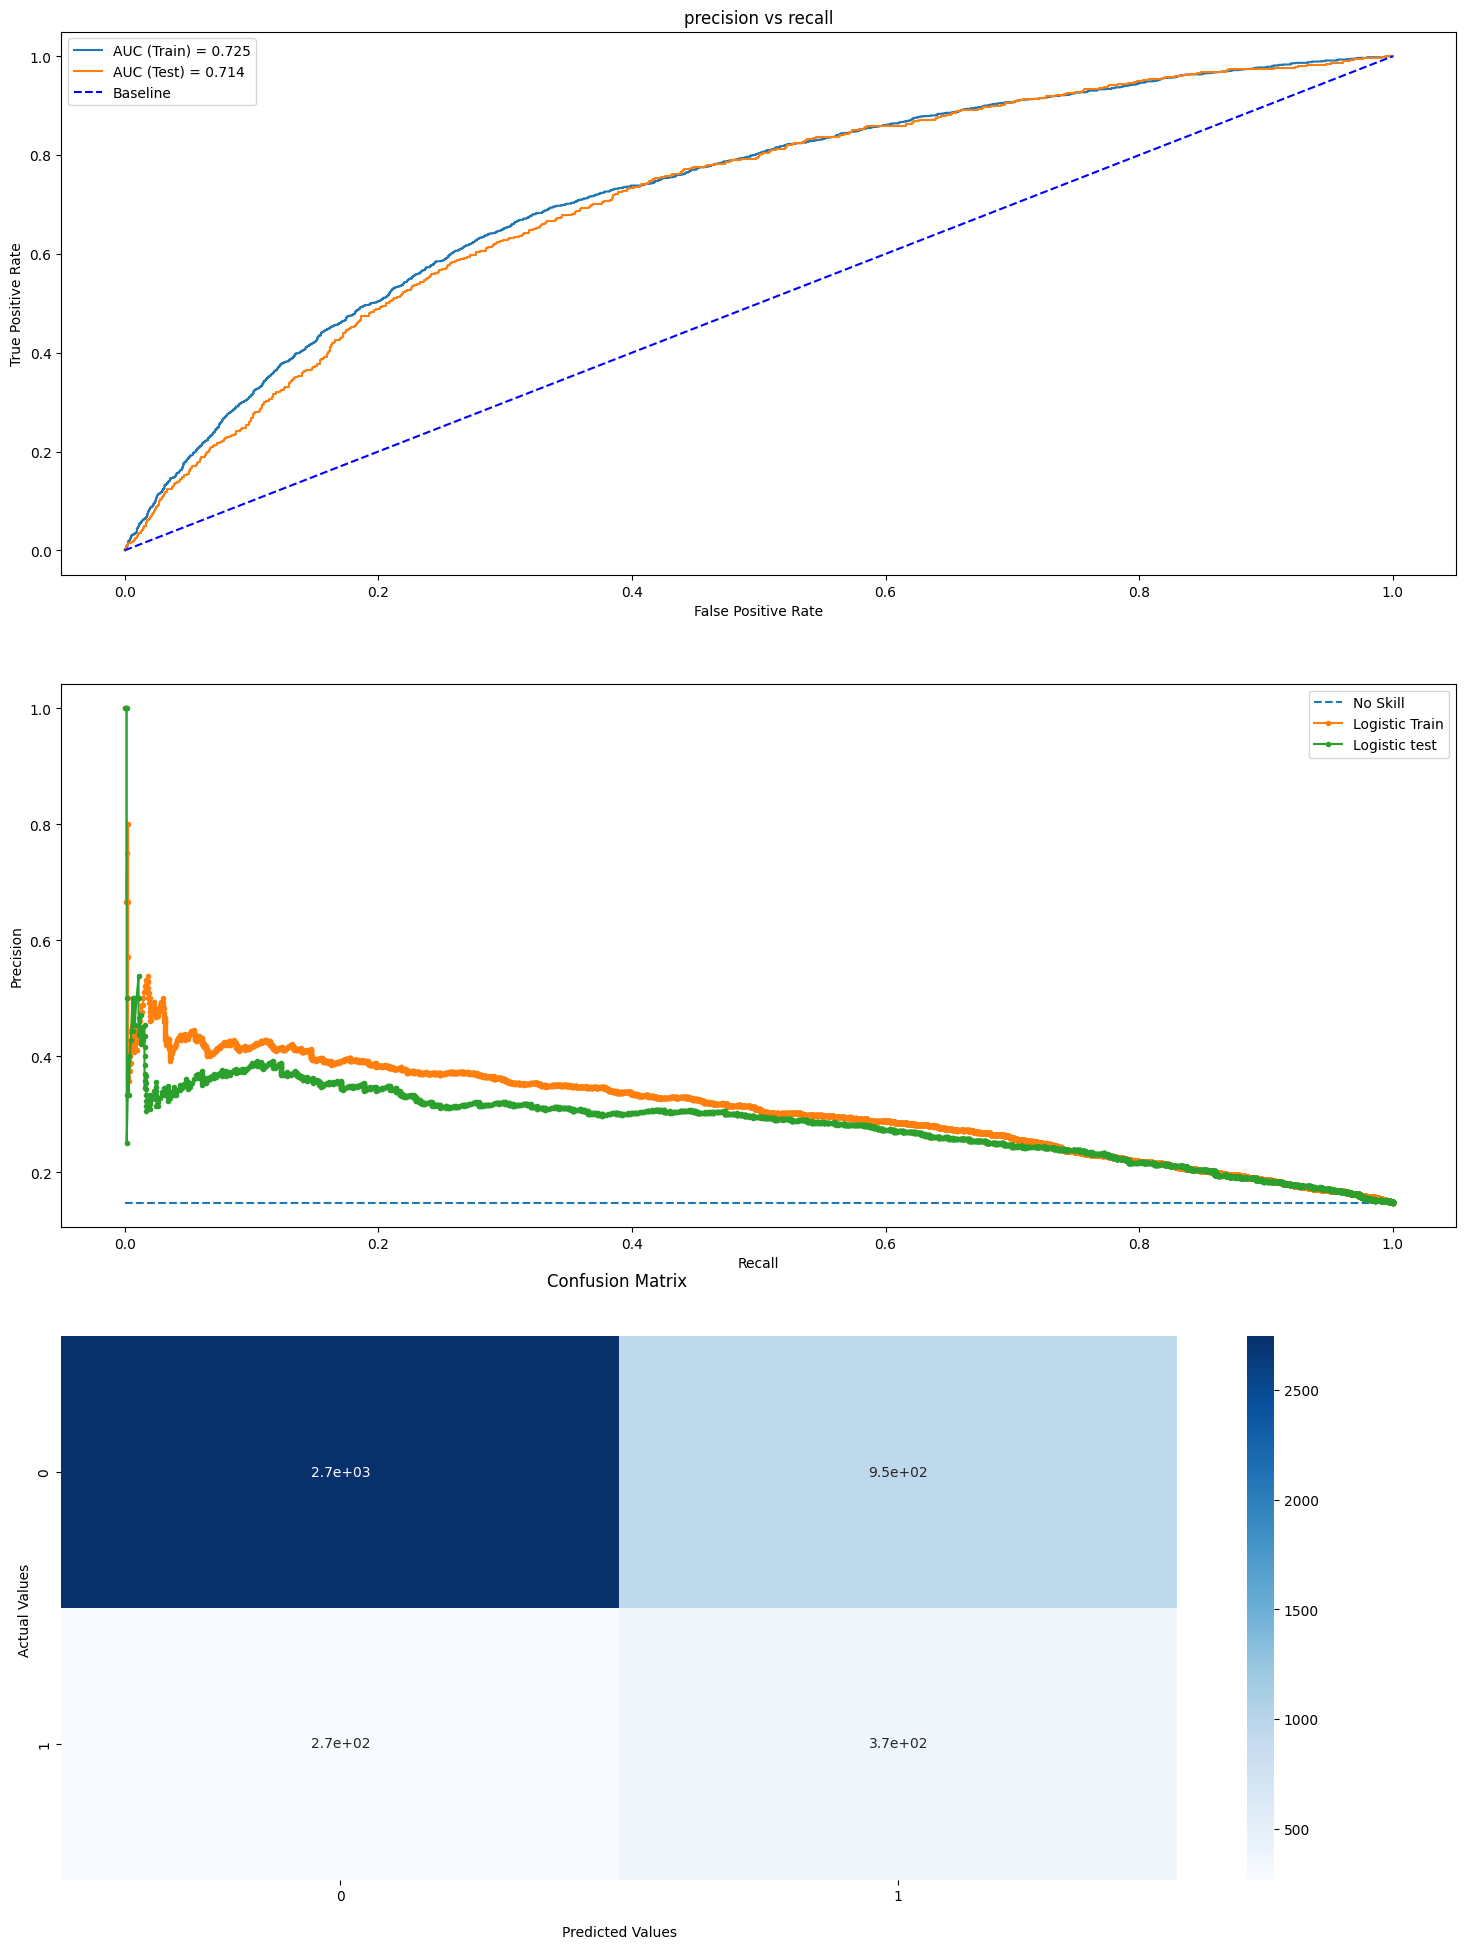

In [230]:
fig, (ax1, ax2,ax3) = plt.subplots(3, 1,figsize=(18,24))

auc_train = roc_auc_score(y_train,X_train['pred_proba'])
fpr_train, tpr_train, thresholds_train = roc_curve(y_train,X_train['pred_proba'])
precision_train, recall_train, thresholds_train = precision_recall_curve(y_train,X_train['pred_proba'])

fpr_df3, tpr_df3, thresholds_df3 = roc_curve(y_test, X_test['pred_proba'])

y_pred = (X_test['pred_proba'] > thresholds[np.argmax(f1_scores)]).astype('float')
cf_matrix=confusion_matrix(y_test, y_pred)

ax1.plot(fpr_train, tpr_train, label=f'AUC (Train) = {auc_train:.3f}')
ax1.plot(fpr_df3, tpr_df3, label=f'AUC (Test) = {auc_score:.3f}')
ax1.plot([0, 1], [0, 1], color='blue', linestyle='--', label='Baseline')
ax1.set_title('ROC Curve', size=12)
ax1.set_xlabel('False Positive Rate', size=10)
ax1.set_ylabel('True Positive Rate', size=10)
ax1.legend()


no_skill = len(y_test[y_test==1]) / len(y_test)
ax2.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
ax2.plot(recall_train, precision_train, marker='.', label='Logistic Train')
ax2.plot(recall, precision, marker='.', label='Logistic test')
ax1.set_title('precision vs recall', size=12)
ax2.set_xlabel('Recall', size=10)
ax2.set_ylabel('Precision', size=10)
ax2.legend()

ax3 = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax3.set_title('Confusion Matrix \n\n')
ax3.set_xlabel('\nPredicted Values')
ax3.set_ylabel('Actual Values ')

ax3.xaxis.set_ticklabels([0,1])
ax3.yaxis.set_ticklabels([0,1])

In [231]:
filename = 'outputs/models/lr_target_model.sav'
pickle.dump(lr, open(filename, 'wb'))

#### Cross validation

In [232]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=2)
auc_stratified_train=[]
auc_stratified_test=[]
f1_score_test=[]
precision_test=[]
recall_test=[]
thresholds_test=[]

for train_index, test_index in skf.split(df_train.drop(columns=[y]), df_train[y]):
    x_train_fold, x_test_fold = df_train.iloc[train_index][columns_to_train], df_train.iloc[test_index][columns_to_train]
    y_train_fold, y_test_fold = df_train.iloc[train_index][y], df_train.iloc[test_index][y]
    encoder = TargetEncoder(cols=categoricals_to_index)
    encoder.fit(x_train_fold, y_train_fold)
    x_train_fold=encoder.transform(x_train_fold)
    x_test_fold = encoder.transform(x_test_fold)
    scaler = StandardScaler()
    x_train_fold=scaler.fit_transform(x_train_fold)
    x_test_fold=scaler.fit_transform(x_test_fold)
    lr = LogisticRegression(random_state=0)
    lr.fit(x_train_fold, y_train_fold)
    auc_stratified_train.append(roc_auc_score(y_train_fold, lr.predict_proba(x_train_fold)[:,1]))
    auc_stratified_test.append(roc_auc_score(y_test_fold, lr.predict_proba(x_test_fold)[:,1]))
    precision, recall, thresholds = precision_recall_curve(y_test_fold, lr.predict_proba(x_test_fold)[:,1])
    f1_scores = 2*recall*precision/(recall+precision)
    f1_score_test.append(np.max(f1_scores))
    precision_test.append(precision[np.argmax(f1_scores)])
    recall_test.append(recall[np.argmax(f1_scores)])
    thresholds_test.append(thresholds[np.argmax(f1_scores)])


print('\nOverall AUC train:',
      np.mean(auc_stratified_train)*100)
print('\nOverall AUC test:',
      np.mean(auc_stratified_test)*100)
print('\nStandard Deviation in train is:', np.std(auc_stratified_train))
print('\nStandard Deviation in test is:', np.std(auc_stratified_test))
print('\nOverall F1 Score test:',
      np.mean(f1_score_test)*100)
print('\nOverall Precision test:',
      np.mean(precision_test)*100)
print('\nOverall Recall test:',
      np.mean(recall_test)*100)
print('\nOverall thresholds test:',
      np.mean(thresholds_test)*100)
metrics=metrics._append({'Model':'Logistic',
                'Encoding':'Target',
                'Balancing':'Ninguna',
                'AUC':np.mean(auc_stratified_test),
                'F1_score':np.mean(f1_score_test),
                'Precision':np.mean(precision_test),
                'Recall':np.mean(recall_test),
                'threshold':np.mean(thresholds_test),
                'flag_cv':1},
                ignore_index = True)


Overall AUC train: 72.6384536809587

Overall AUC test: 71.32078538471879

Standard Deviation in train is: 0.004799559581931253

Standard Deviation in test is: 0.012721302103706497

Overall F1 Score test: nan

Overall Precision test: 9.637987776210625

Overall Recall test: 19.221753398968588

Overall thresholds test: 43.55757425635394


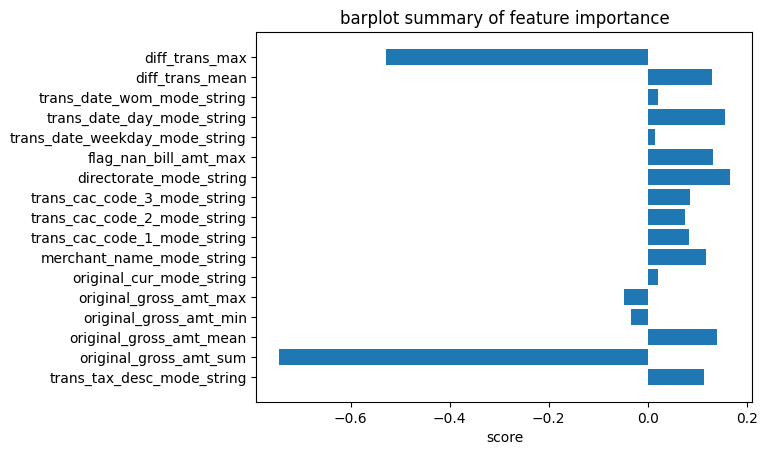

In [233]:
importance=lr.coef_.flatten()
plt.barh(columns_to_train,importance)
plt.title('barplot summary of feature importance')
plt.xlabel('score')
plt.show()

In [234]:
importance_df=pd.DataFrame({'variables':columns_to_train,
                            'importancia':np.abs(importance)})
importance_df.sort_values('importancia',ascending=False,inplace=True)
importance_df.head()

,variables,importancia
1,original_gross_amt_sum,0.744973
16,diff_trans_max,0.528976
10,directorate_mode_string,0.166046
13,trans_date_day_mode_string,0.155973
2,original_gross_amt_mean,0.139973


#### variable por decil

In [235]:
variables=list(importance_df.iloc[:5,0])
numericas=list(set(df_train.select_dtypes(exclude='object').columns).intersection(set(variables)))
valdata['grupo'] = pd.cut(valdata.pred_proba,
        bins=[-1, valdata['pred_proba'].quantile(0.1), valdata['pred_proba'].quantile(0.2), valdata['pred_proba'].quantile(0.3),
               valdata['pred_proba'].quantile(0.4), valdata['pred_proba'].quantile(0.5), valdata['pred_proba'].quantile(0.6),
               valdata['pred_proba'].quantile(0.7), valdata['pred_proba'].quantile(0.8), valdata['pred_proba'].quantile(0.9), 1],
        labels=['Decil 10','Decil 9','Decil 8','Decil 7','Decil 6','Decil 5','Decil 4','Decil 3','Decil 2','Decil 1'])

In [ ]:
for var in numericas:
    plt.figure(figsize=(16,10))
    sns.boxplot(x='grupo',y=var,data=valdata, palette='rainbow',order=['Decil 10','Decil 9','Decil 8','Decil 7','Decil 6','Decil 5','Decil 4','Decil 3','Decil 2','Decil 1'])
    plt.show()

### random forest

#### target encoding

In [237]:
X_train, X_test, y_train, y_test = train_test_split(df_train[columns_to_train], df_train[y], 
                                                    test_size=0.3, random_state=42,
                                                    stratify=df_train[y])

In [238]:
encoder = TargetEncoder(cols=categoricals_to_index)
encoder.fit(X_train, y_train)
X_train = encoder.transform(X_train)
X_test = encoder.transform(X_test)

In [239]:
params={'bootstrap': True,
 'max_depth': 15,
 'max_features': 'auto',
 'min_samples_leaf': 4,
 'min_samples_split': 10,
 'n_estimators': 100,
 'random_state':0,
 'class_weight':'balanced'}

rf = RandomForestClassifier(**params)
rf.fit(X_train[columns_to_train], y_train)
X_train['pred_label']=rf.predict(X_train[columns_to_train])
X_train['pred_proba']=rf.predict_proba(X_train[columns_to_train])[:,1]
X_test['pred_label']=rf.predict(X_test[columns_to_train])
X_test['pred_proba']=rf.predict_proba(X_test[columns_to_train])[:,1]
auc_score=roc_auc_score(y_test, X_test['pred_proba'])
precision, recall, thresholds = precision_recall_curve(y_test, X_test['pred_proba'])
f1_scores = 2*recall*precision/(recall+precision)
print('AUC: ',auc_score)
print('Best threshold: ', thresholds[np.argmax(f1_scores)])
print('Best F1-Score: ', np.max(f1_scores))
print('Best Recall: ', recall[np.argmax(f1_scores)])
print('Best precision: ', precision[np.argmax(f1_scores)])
metrics=metrics._append({'Model':'Random Forest',
                'Encoding':'Target',
                'Balancing':'Hyperparemeter',
                'AUC':auc_score,
                'F1_score':np.max(f1_scores),
                'Precision':precision[np.argmax(f1_scores)],
                'Recall':recall[np.argmax(f1_scores)],
                'threshold':thresholds[np.argmax(f1_scores)],
                'flag_cv':0},
                ignore_index = True)

AUC:  0.7458038495395448
Best threshold:  0.42710253320990593
Best F1-Score:  0.39903264812575573
Best Recall:  0.515625
Best precision:  0.3254437869822485


In [240]:
valdata=X_test.copy()
valdata['target']=y_test
dfks=ks_table(valdata[['target','pred_proba']],target='target', prob='pred_proba')
dfks.to_csv('outputs/ks/ks_random.csv')

        min_prob  max_prob  events  nonevents event_rate nonevent_rate  \
Decile                                                                   
1       0.581536  0.902879   169.0      265.0     26.41%         7.18%   
2       0.461229  0.581290   124.0      309.0     19.38%         8.37%   
3       0.363999  0.460827    82.0      351.0     12.81%         9.51%   
4       0.287578  0.363880    77.0      356.0     12.03%         9.64%   
5       0.233492  0.287076    64.0      369.0     10.00%         9.99%   
6       0.185672  0.233408    42.0      391.0      6.56%        10.59%   
7       0.151768  0.185662    37.0      396.0      5.78%        10.73%   
8       0.121667  0.151753    21.0      412.0      3.28%        11.16%   
9       0.086655  0.121590    18.0      415.0      2.81%        11.24%   
10      0.006933  0.086583     6.0      428.0      0.94%        11.59%   

       cum_eventrate cum_noneventrate    KS  
Decile                                       
1             26.41

[Text(0, 0.5, '0'), Text(0, 1.5, '1')]

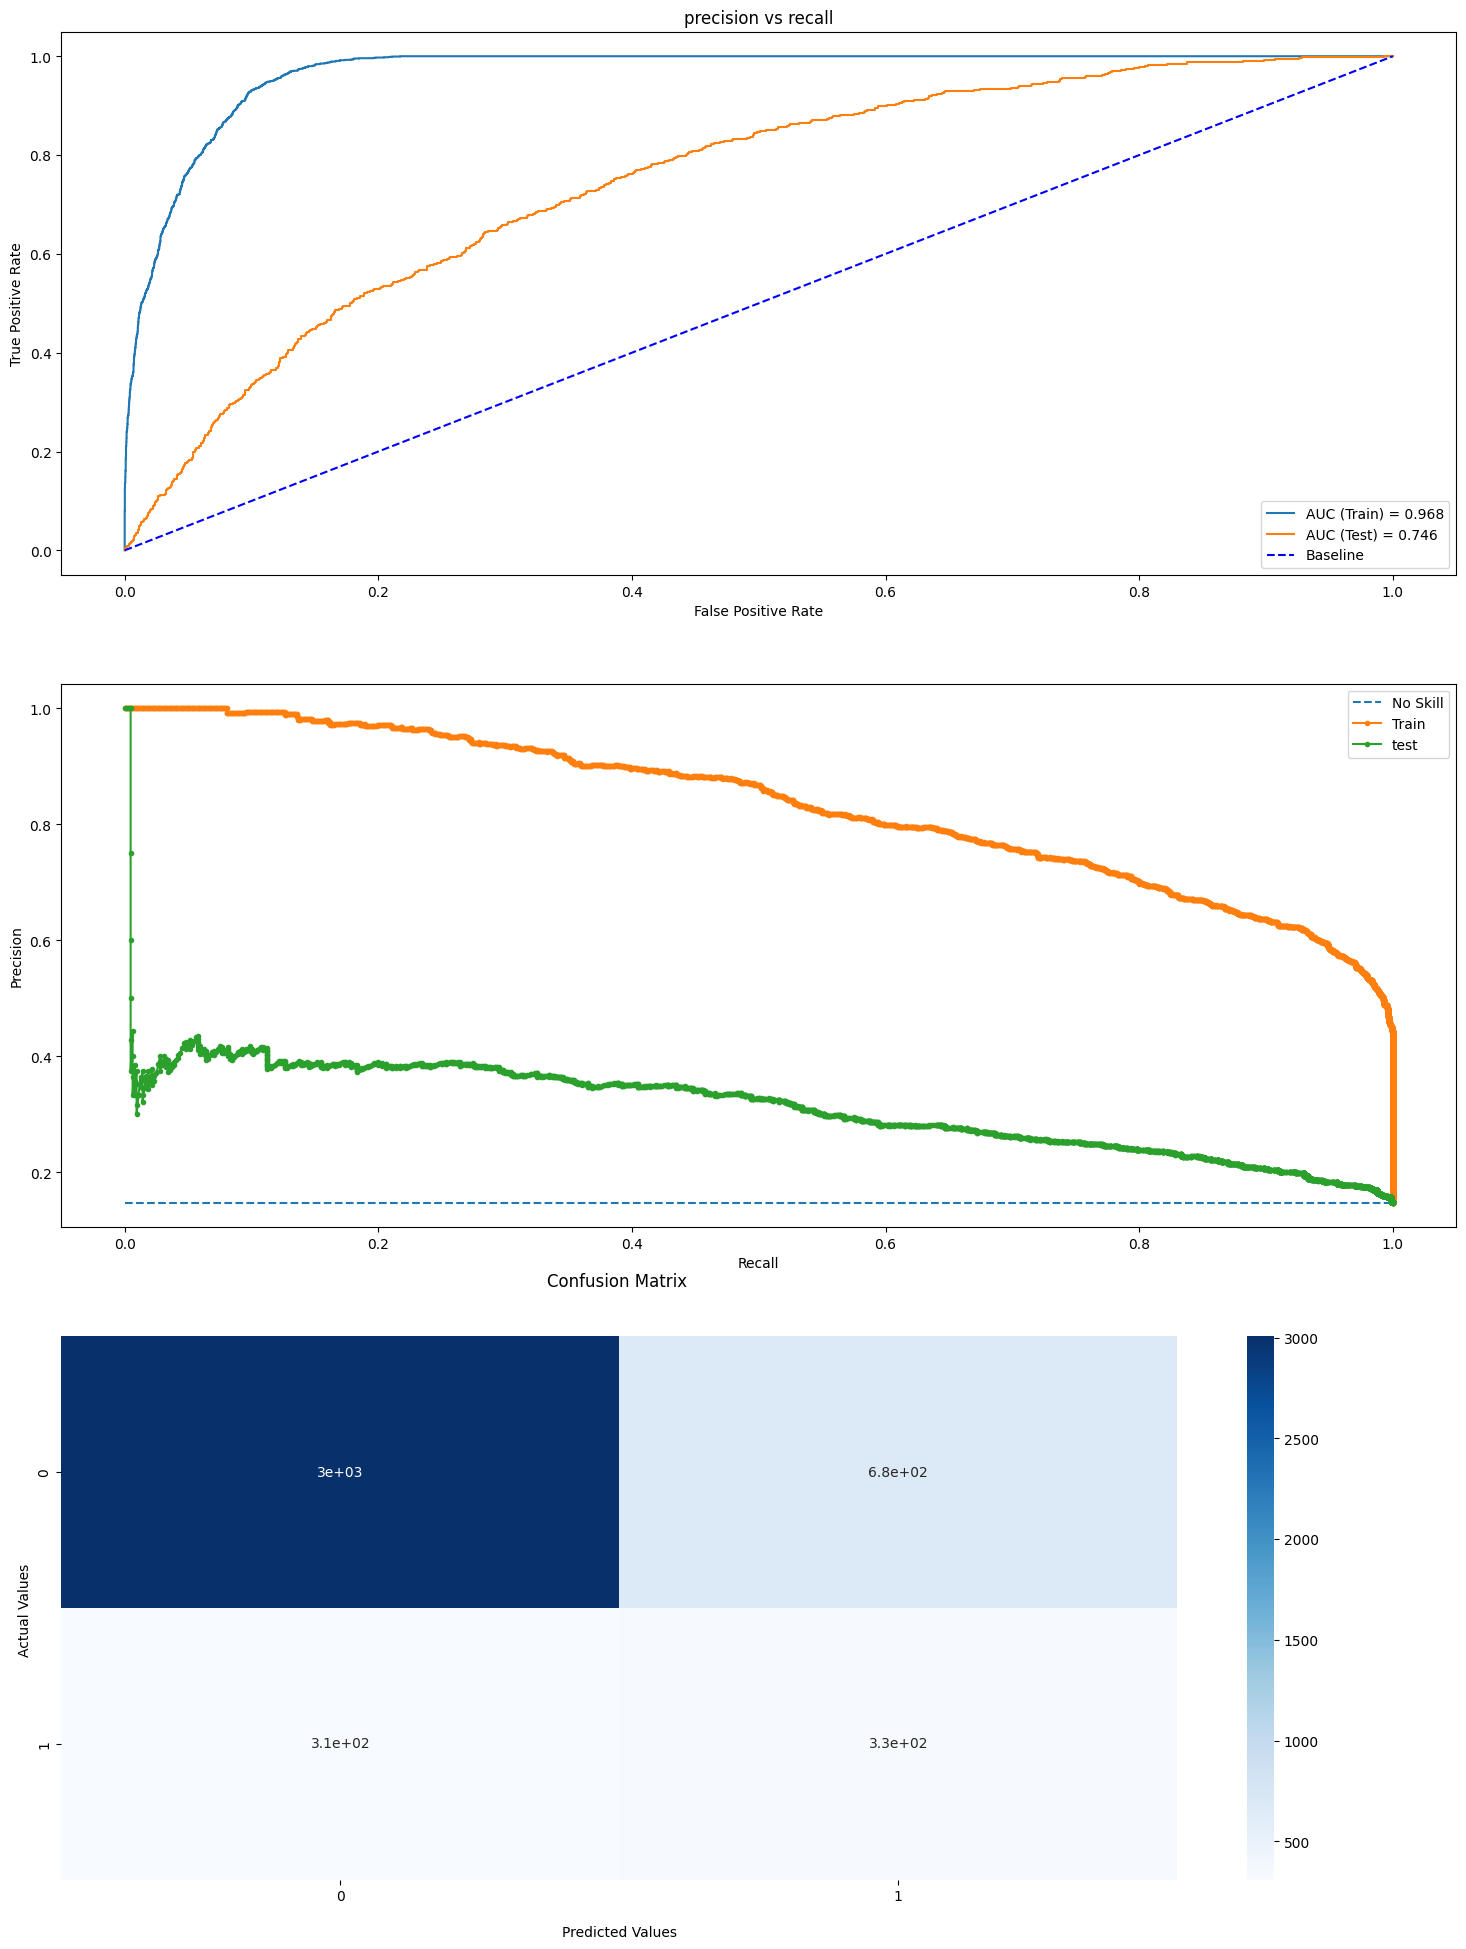

In [241]:
fig, (ax1, ax2,ax3) = plt.subplots(3, 1,figsize=(18,24))

auc_train = roc_auc_score(y_train,X_train['pred_proba'])
fpr_train, tpr_train, thresholds_train = roc_curve(y_train,X_train['pred_proba'])
precision_train, recall_train, thresholds_train = precision_recall_curve(y_train,X_train['pred_proba'])

fpr_df3, tpr_df3, thresholds_df3 = roc_curve(y_test, X_test['pred_proba'])

y_pred = (X_test['pred_proba'] > thresholds[np.argmax(f1_scores)]).astype('float')
cf_matrix=confusion_matrix(y_test, y_pred)

ax1.plot(fpr_train, tpr_train, label=f'AUC (Train) = {auc_train:.3f}')
ax1.plot(fpr_df3, tpr_df3, label=f'AUC (Test) = {auc_score:.3f}')
ax1.plot([0, 1], [0, 1], color='blue', linestyle='--', label='Baseline')
ax1.set_title('ROC Curve', size=12)
ax1.set_xlabel('False Positive Rate', size=10)
ax1.set_ylabel('True Positive Rate', size=10)
ax1.legend()


no_skill = len(y_test[y_test==1]) / len(y_test)
ax2.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
ax2.plot(recall_train, precision_train, marker='.', label='Train')
ax2.plot(recall, precision, marker='.', label='test')
ax1.set_title('precision vs recall', size=12)
ax2.set_xlabel('Recall', size=10)
ax2.set_ylabel('Precision', size=10)
ax2.legend()

ax3 = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax3.set_title('Confusion Matrix \n\n')
ax3.set_xlabel('\nPredicted Values')
ax3.set_ylabel('Actual Values ')

ax3.xaxis.set_ticklabels([0,1])
ax3.yaxis.set_ticklabels([0,1])

##### Cross validation

In [242]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=2)
auc_stratified_train=[]
auc_stratified_test=[]
f1_score_test=[]
precision_test=[]
recall_test=[]
thresholds_test=[]

for train_index, test_index in skf.split(df_train.drop(columns=[y]), df_train[y]):
    x_train_fold, x_test_fold = df_train.iloc[train_index][columns_to_train], df_train.iloc[test_index][columns_to_train]
    y_train_fold, y_test_fold = df_train.iloc[train_index][y], df_train.iloc[test_index][y]
    encoder = TargetEncoder(cols=categoricals_to_index)
    encoder.fit(x_train_fold, y_train_fold)
    x_train_fold=encoder.transform(x_train_fold)
    x_test_fold = encoder.transform(x_test_fold)
    params={'bootstrap': True,
      'max_depth': 15,
      'max_features': 'auto',
      'min_samples_leaf': 4,
      'min_samples_split': 10,
      'n_estimators': 100,
      'random_state':0,
      'class_weight':'balanced'}

    rf = RandomForestClassifier(**params)
    rf.fit(x_train_fold, y_train_fold)
    auc_stratified_train.append(roc_auc_score(y_train_fold, rf.predict_proba(x_train_fold)[:,1]))
    auc_stratified_test.append(roc_auc_score(y_test_fold, rf.predict_proba(x_test_fold)[:,1]))
    precision, recall, thresholds = precision_recall_curve(y_test_fold, rf.predict_proba(x_test_fold)[:,1])
    f1_scores = 2*recall*precision/(recall+precision)
    f1_score_test.append(np.max(f1_scores))
    precision_test.append(precision[np.argmax(f1_scores)])
    recall_test.append(recall[np.argmax(f1_scores)])
    thresholds_test.append(thresholds[np.argmax(f1_scores)])


print('\nOverall AUC train:',
      np.mean(auc_stratified_train)*100)
print('\nOverall AUC test:',
      np.mean(auc_stratified_test)*100)
print('\nStandard Deviation in train is:', np.std(auc_stratified_train))
print('\nStandard Deviation in test is:', np.std(auc_stratified_test))
print('\nOverall F1 Score test:',
      np.mean(f1_score_test)*100)
print('\nOverall Precision test:',
      np.mean(precision_test)*100)
print('\nOverall Recall test:',
      np.mean(recall_test)*100)
print('\nOverall thresholds test:',
      np.mean(thresholds_test)*100)
metrics=metrics._append({'Model':'Random Forest',
                'Encoding':'Target',
                'Balancing':'Hyperparameter',
                'AUC':np.mean(auc_stratified_test),
                'F1_score':np.mean(f1_score_test),
                'Precision':np.mean(precision_test),
                'Recall':np.mean(recall_test),
                'threshold':np.mean(thresholds_test),
                'flag_cv':1},
                ignore_index = True)


Overall AUC train: 96.53763333271192

Overall AUC test: 74.00941970302685

Standard Deviation in train is: 0.0011664298160678874

Standard Deviation in test is: 0.00795494385487526

Overall F1 Score test: nan

Overall Precision test: 18.318184488609823

Overall Recall test: 35.08196721311475

Overall thresholds test: 57.89114210658515


In [243]:
feature_importances_lgb = pd.DataFrame (rf.feature_importances_, 
                                                index = X_test[columns_to_train].columns, 
                                                columns = ['importance'])
feature_importances_lgb.sort_values('importance', ascending = False, inplace = True)
feature_importances_lgb

,importance
original_gross_amt_sum,0.157943
diff_trans_max,0.119116
diff_trans_mean,0.112265
original_gross_amt_max,0.110709
original_gross_amt_min,0.105660
original_gross_amt_mean,0.098212
trans_date_day_mode_string,0.072365
directorate_mode_string,0.041823
trans_cac_code_1_mode_string,0.040544
trans_date_weekday_mode_string,0.035827


##### variable por decil

In [244]:
variables=list(feature_importances_lgb.iloc[:5,0].index)
numericas=list(set(df_train.select_dtypes(exclude='object').columns).intersection(set(variables)))
valdata['grupo'] = pd.cut(valdata.pred_proba,
        bins=[-1, valdata['pred_proba'].quantile(0.1), valdata['pred_proba'].quantile(0.2), valdata['pred_proba'].quantile(0.3),
               valdata['pred_proba'].quantile(0.4), valdata['pred_proba'].quantile(0.5), valdata['pred_proba'].quantile(0.6),
               valdata['pred_proba'].quantile(0.7), valdata['pred_proba'].quantile(0.8), valdata['pred_proba'].quantile(0.9), 1],
        labels=['Decil 10','Decil 9','Decil 8','Decil 7','Decil 6','Decil 5','Decil 4','Decil 3','Decil 2','Decil 1'])

In [ ]:
for var in numericas:
    plt.figure(figsize=(16,10))
    sns.boxplot(x='grupo',y=var,data=valdata, palette='rainbow',order=['Decil 10','Decil 9','Decil 8','Decil 7','Decil 6','Decil 5','Decil 4','Decil 3','Decil 2','Decil 1'])
    plt.show()

#### frequency encoding

In [259]:
X_train, X_test, y_train, y_test = train_test_split(df_train[columns_to_train], df_train[y], 
                                                    test_size=0.3, random_state=42,
                                                    stratify=df_train[y])

In [260]:
encoder = FrequencyEncoder(cols=categoricals_to_index)
encoder.fit(X_train, y_train)
with open("outputs/encoders/frequency_encoder.pkl", "wb") as f:
    pickle.dump(encoder, f)
X_train = encoder.transform(X_train)
X_test = encoder.transform(X_test)

In [262]:
params={'bootstrap': True,
 'max_depth': 15,
 'max_features': 'auto',
 'min_samples_leaf': 4,
 'min_samples_split': 100,
 'n_estimators': 400,
 'random_state':0,
 'class_weight':'balanced'}

rf = RandomForestClassifier(**params)
rf.fit(X_train[columns_to_train], y_train)
X_train['pred_label']=rf.predict(X_train[columns_to_train])
X_train['pred_proba']=rf.predict_proba(X_train[columns_to_train])[:,1]
X_test['pred_label']=rf.predict(X_test[columns_to_train])
X_test['pred_proba']=rf.predict_proba(X_test[columns_to_train])[:,1]
auc_score=roc_auc_score(y_test, X_test['pred_proba'])
precision, recall, thresholds = precision_recall_curve(y_test, X_test['pred_proba'])
f1_scores = 2*recall*precision/(recall+precision)
print('AUC: ',auc_score)
print('Best threshold: ', thresholds[np.argmax(f1_scores)])
print('Best F1-Score: ', np.max(f1_scores))
print('Best Recall: ', recall[np.argmax(f1_scores)])
print('Best precision: ', precision[np.argmax(f1_scores)])
metrics=metrics._append({'Model':'Random Forest',
                'Encoding':'Frequency',
                'Balancing':'Hyperparemeter',
                'AUC':auc_score,
                'F1_score':np.max(f1_scores),
                'Precision':precision[np.argmax(f1_scores)],
                'Recall':recall[np.argmax(f1_scores)],
                'threshold':thresholds[np.argmax(f1_scores)],
                'flag_cv':0},
                ignore_index = True)

AUC:  0.7453421248645721
Best threshold:  0.8200575304413491
Best F1-Score:  nan
Best Recall:  0.0
Best precision:  0.0


[Text(0, 0.5, '0'), Text(0, 1.5, '1')]

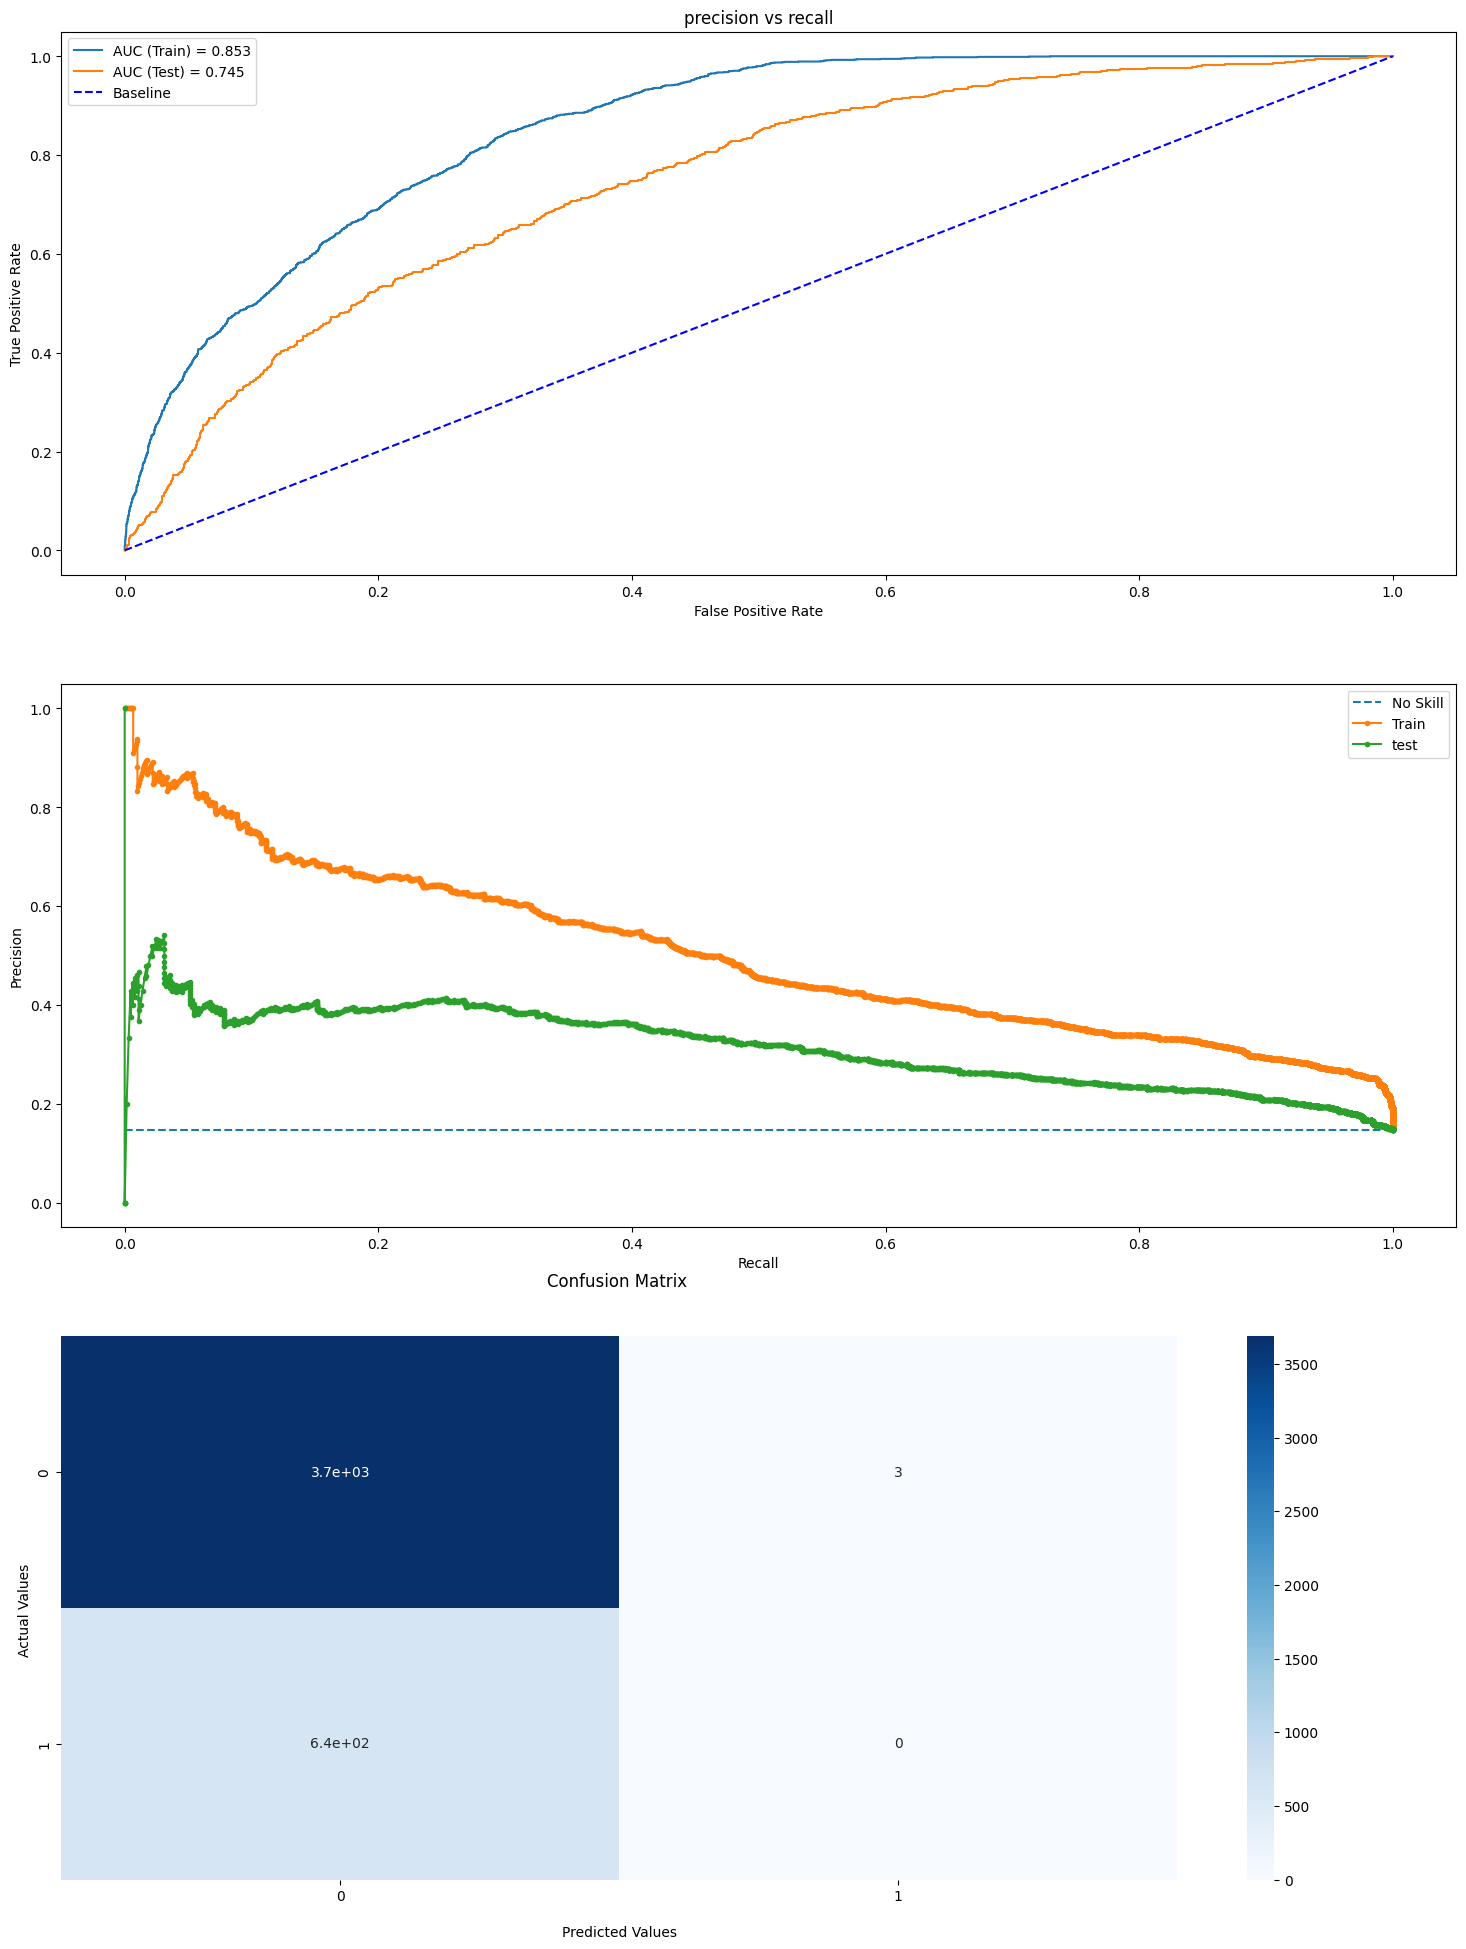

In [263]:
fig, (ax1, ax2,ax3) = plt.subplots(3, 1,figsize=(18,24))

auc_train = roc_auc_score(y_train,X_train['pred_proba'])
fpr_train, tpr_train, thresholds_train = roc_curve(y_train,X_train['pred_proba'])
precision_train, recall_train, thresholds_train = precision_recall_curve(y_train,X_train['pred_proba'])

fpr_df3, tpr_df3, thresholds_df3 = roc_curve(y_test, X_test['pred_proba'])

y_pred = (X_test['pred_proba'] > thresholds[np.argmax(f1_scores)]).astype('float')
cf_matrix=confusion_matrix(y_test, y_pred)

ax1.plot(fpr_train, tpr_train, label=f'AUC (Train) = {auc_train:.3f}')
ax1.plot(fpr_df3, tpr_df3, label=f'AUC (Test) = {auc_score:.3f}')
ax1.plot([0, 1], [0, 1], color='blue', linestyle='--', label='Baseline')
ax1.set_title('ROC Curve', size=12)
ax1.set_xlabel('False Positive Rate', size=10)
ax1.set_ylabel('True Positive Rate', size=10)
ax1.legend()


no_skill = len(y_test[y_test==1]) / len(y_test)
ax2.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
ax2.plot(recall_train, precision_train, marker='.', label='Train')
ax2.plot(recall, precision, marker='.', label='test')
ax1.set_title('precision vs recall', size=12)
ax2.set_xlabel('Recall', size=10)
ax2.set_ylabel('Precision', size=10)
ax2.legend()

ax3 = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax3.set_title('Confusion Matrix \n\n')
ax3.set_xlabel('\nPredicted Values')
ax3.set_ylabel('Actual Values ')

ax3.xaxis.set_ticklabels([0,1])
ax3.yaxis.set_ticklabels([0,1])

##### Cross validation

In [264]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=2)
auc_stratified_train=[]
auc_stratified_test=[]
f1_score_test=[]
precision_test=[]
recall_test=[]
thresholds_test=[]

for train_index, test_index in skf.split(df_train.drop(columns=[y]), df_train[y]):
    x_train_fold, x_test_fold = df_train.iloc[train_index][columns_to_train], df_train.iloc[test_index][columns_to_train]
    y_train_fold, y_test_fold = df_train.iloc[train_index][y], df_train.iloc[test_index][y]
    encoder = FrequencyEncoder(cols=categoricals_to_index)
    encoder.fit(x_train_fold, y_train_fold)
    x_train_fold=encoder.transform(x_train_fold)
    x_test_fold = encoder.transform(x_test_fold)
    params={'bootstrap': True,
      'max_depth': 15,
      'max_features': 'auto',
      'min_samples_leaf': 4,
      'min_samples_split': 100,
      'n_estimators': 400,
      'random_state':0,
      'class_weight':'balanced'}

    rf = RandomForestClassifier(**params)
    rf.fit(x_train_fold, y_train_fold)
    auc_stratified_train.append(roc_auc_score(y_train_fold, rf.predict_proba(x_train_fold)[:,1]))
    auc_stratified_test.append(roc_auc_score(y_test_fold, rf.predict_proba(x_test_fold)[:,1]))
    precision, recall, thresholds = precision_recall_curve(y_test_fold, rf.predict_proba(x_test_fold)[:,1])
    f1_scores = 2*recall*precision/(recall+precision)
    f1_score_test.append(np.max(f1_scores))
    precision_test.append(precision[np.argmax(f1_scores)])
    recall_test.append(recall[np.argmax(f1_scores)])
    thresholds_test.append(thresholds[np.argmax(f1_scores)])


print('\nOverall AUC train:',
      np.mean(auc_stratified_train)*100)
print('\nOverall AUC test:',
      np.mean(auc_stratified_test)*100)
print('\nStandard Deviation in train is:', np.std(auc_stratified_train))
print('\nStandard Deviation in test is:', np.std(auc_stratified_test))
print('\nOverall F1 Score test:',
      np.mean(f1_score_test)*100)
print('\nOverall Precision test:',
      np.mean(precision_test)*100)
print('\nOverall Recall test:',
      np.mean(recall_test)*100)
print('\nOverall thresholds test:',
      np.mean(thresholds_test)*100)
metrics=metrics._append({'Model':'Random Forest',
                'Encoding':'Frequency',
                'Balancing':'Hyperparameter',
                'AUC':np.mean(auc_stratified_test),
                'F1_score':np.mean(f1_score_test),
                'Precision':np.mean(precision_test),
                'Recall':np.mean(recall_test),
                'threshold':np.mean(thresholds_test),
                'flag_cv':1},
                ignore_index = True)


Overall AUC train: 85.49735366998114

Overall AUC test: 74.31002023223733

Standard Deviation in train is: 0.0009486754724070445

Standard Deviation in test is: 0.006771273735557135

Overall F1 Score test: nan

Overall Precision test: 19.00890331047987

Overall Recall test: 36.14396763092215

Overall thresholds test: 64.0825541054429


### xgboost

#### target encoding

In [265]:
X_train, X_test, y_train, y_test = train_test_split(df_train[columns_to_train], df_train[y], 
                                                    test_size=0.3, random_state=42,
                                                    stratify=df_train[y])

In [266]:
encoder = TargetEncoder(cols=categoricals_to_index)
encoder.fit(X_train, y_train)
X_train = encoder.transform(X_train)
X_test = encoder.transform(X_test)

In [267]:
dtrain = xgb.DMatrix(X_train[columns_to_train], label=y_train)
dvalid = xgb.DMatrix(X_test[columns_to_train], label=y_test)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

In [268]:
params = {
            'objective':'binary:logistic',
            'max_depth': 4,
            'alpha': 10,
            'learning_rate': 1.0,
            'n_estimators':100,
            'random_state':42,
            'eval_metric':'auc'
        }

model = xgb.train(params, dtrain, 10, watchlist, early_stopping_rounds=2,verbose_eval=1)
#X_train['pred_label']=model.predict(X_train[columns_to_train])
X_train['pred_proba']=model.predict(dtrain)
#X_test['pred_label']=model.predict(X_test[columns_to_train])
X_test['pred_proba']=model.predict(dvalid)
auc_score=roc_auc_score(y_test, X_test['pred_proba'])
precision, recall, thresholds = precision_recall_curve(y_test, X_test['pred_proba'])
f1_scores = 2*recall*precision/(recall+precision)
print('AUC: ',auc_score)
print('Best threshold: ', thresholds[np.argmax(f1_scores)])
print('Best F1-Score: ', np.max(f1_scores))
print('Best Recall: ', recall[np.argmax(f1_scores)])
print('Best precision: ', precision[np.argmax(f1_scores)])
metrics=metrics._append({'Model':'XGBoost',
                'Encoding':'Target',
                'Balancing':'Ninguno',
                'AUC':auc_score,
                'F1_score':np.max(f1_scores),
                'Precision':precision[np.argmax(f1_scores)],
                'Recall':recall[np.argmax(f1_scores)],
                'threshold':thresholds[np.argmax(f1_scores)],
                'flag_cv':0},
                ignore_index = True)

[23:37:59] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	train-auc:0.70253	valid-auc:0.70732
[1]	train-auc:0.73167	valid-auc:0.71682
[2]	train-auc:0.74782	valid-auc:0.71923
[3]	train-auc:0.75874	valid-auc:0.72022
[4]	train-auc:0.76443	valid-auc:0.72116
[5]	train-auc:0.77277	valid-auc:0.72286
[6]	train-auc:0.78135	valid-auc:0.71961
[7]	train-auc:0.78415	valid-auc:0.71833
AUC:  0.7183282688921994
Best threshold:  0.75381523
Best F1-Score:  nan
Best Recall:  0.0
Best precision:  0.0


In [270]:
valdata=X_test.copy()
valdata['target']=y_test
dfks=ks_table(valdata[['target','pred_proba']],target='target', prob='pred_proba')
dfks.to_csv('outputs/ks/ks_xgboost.csv')

        min_prob  max_prob  events  nonevents event_rate nonevent_rate  \
Decile                                                                   
1       0.336261  0.753815   151.0      283.0     23.59%         7.67%   
2       0.251653  0.335605   124.0      309.0     19.38%         8.37%   
3       0.185389  0.251552    81.0      351.0     12.66%         9.51%   
4       0.136662  0.185357    80.0      354.0     12.50%         9.59%   
5       0.101667  0.136630    56.0      377.0      8.75%        10.21%   
6       0.076540  0.101632    49.0      384.0      7.66%        10.40%   
7       0.057945  0.076494    35.0      397.0      5.47%        10.75%   
8       0.043303  0.057890    32.0      402.0      5.00%        10.89%   
9       0.031143  0.043164    18.0      415.0      2.81%        11.24%   
10      0.009607  0.031127    14.0      420.0      2.19%        11.38%   

       cum_eventrate cum_noneventrate    KS  
Decile                                       
1             23.59

[Text(0, 0.5, '0'), Text(0, 1.5, '1')]

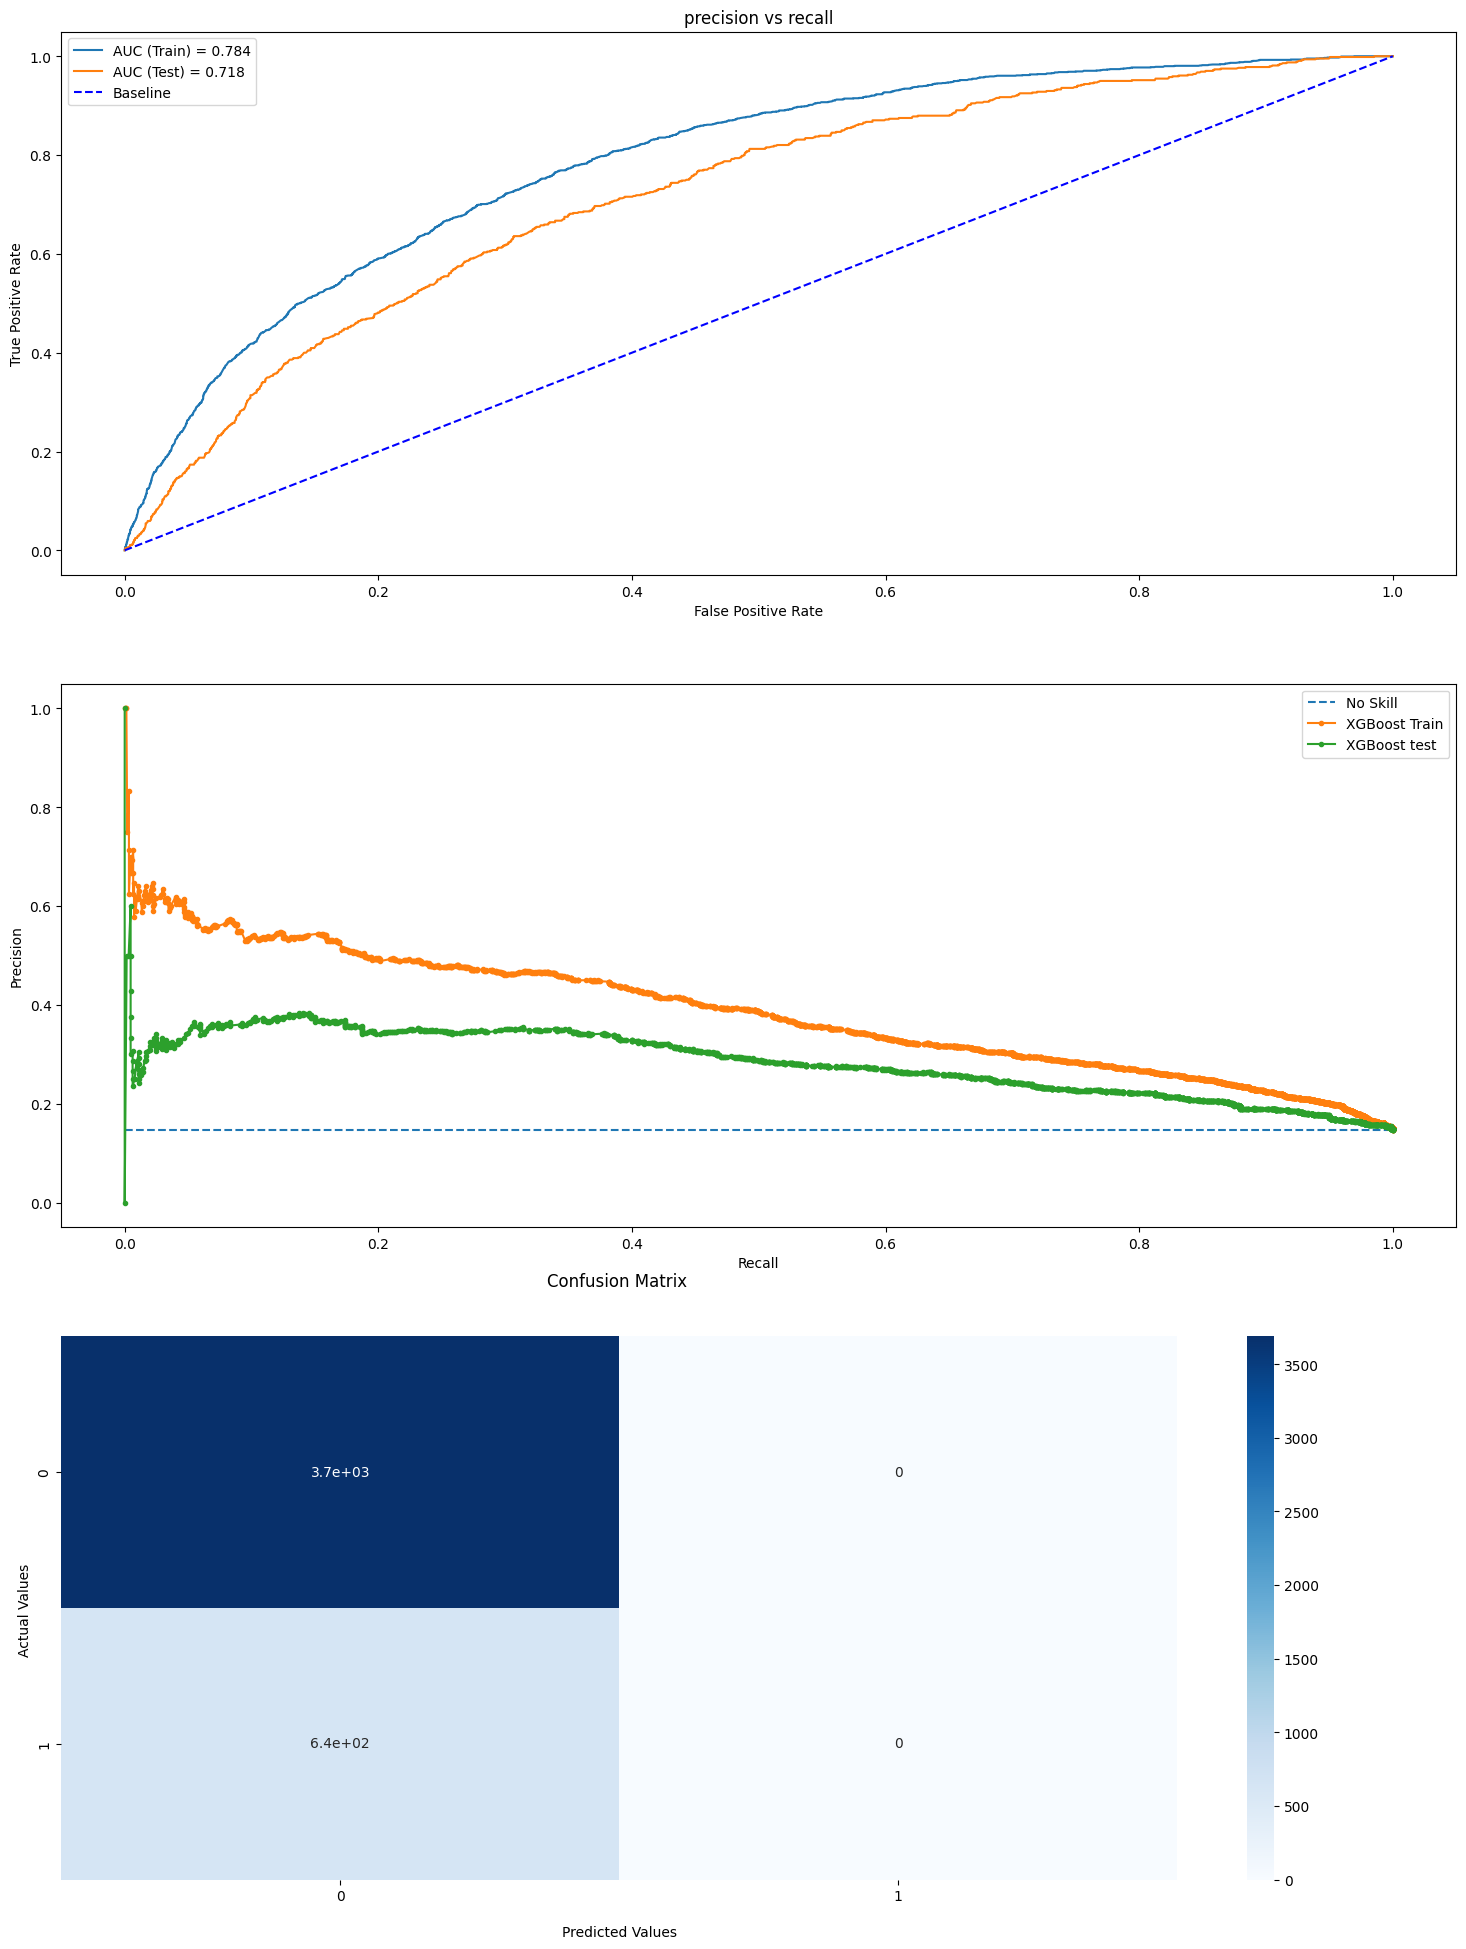

In [271]:
fig, (ax1, ax2,ax3) = plt.subplots(3, 1,figsize=(18,24))

auc_train = roc_auc_score(y_train,X_train['pred_proba'])
fpr_train, tpr_train, thresholds_train = roc_curve(y_train,X_train['pred_proba'])
precision_train, recall_train, thresholds_train = precision_recall_curve(y_train,X_train['pred_proba'])

fpr_df3, tpr_df3, thresholds_df3 = roc_curve(y_test, X_test['pred_proba'])

y_pred = (X_test['pred_proba'] > thresholds[np.argmax(f1_scores)]).astype('float')
cf_matrix=confusion_matrix(y_test, y_pred)

ax1.plot(fpr_train, tpr_train, label=f'AUC (Train) = {auc_train:.3f}')
ax1.plot(fpr_df3, tpr_df3, label=f'AUC (Test) = {auc_score:.3f}')
ax1.plot([0, 1], [0, 1], color='blue', linestyle='--', label='Baseline')
ax1.set_title('ROC Curve', size=12)
ax1.set_xlabel('False Positive Rate', size=10)
ax1.set_ylabel('True Positive Rate', size=10)
ax1.legend()


no_skill = len(y_test[y_test==1]) / len(y_test)
ax2.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
ax2.plot(recall_train, precision_train, marker='.', label='XGBoost Train')
ax2.plot(recall, precision, marker='.', label='XGBoost test')
ax1.set_title('precision vs recall', size=12)
ax2.set_xlabel('Recall', size=10)
ax2.set_ylabel('Precision', size=10)
ax2.legend()

ax3 = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax3.set_title('Confusion Matrix \n\n')
ax3.set_xlabel('\nPredicted Values')
ax3.set_ylabel('Actual Values ')

ax3.xaxis.set_ticklabels([0,1])
ax3.yaxis.set_ticklabels([0,1])

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

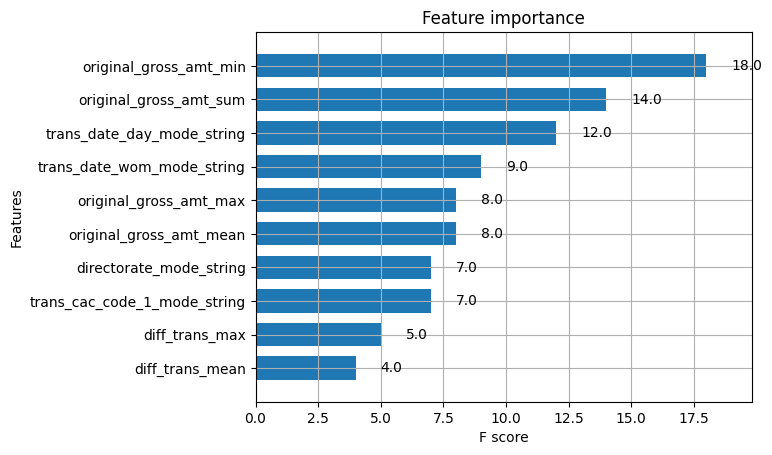

In [272]:
xgb.plot_importance(model, max_num_features=10, height=0.7)

In [273]:
importance_df=pd.DataFrame(model.get_fscore().items(), columns=['feature','importance']).sort_values('importance', ascending=False)
importance_df.head()

,feature,importance
3,original_gross_amt_min,18.0
1,original_gross_amt_sum,14.0
10,trans_date_day_mode_string,12.0
11,trans_date_wom_mode_string,9.0
2,original_gross_amt_mean,8.0


##### Variable por decil

In [274]:
variables=list(importance_df.iloc[:5,0])
numericas=list(set(df_train.select_dtypes(exclude='object').columns).intersection(set(variables)))
valdata['grupo'] = pd.cut(valdata.pred_proba,
        bins=[-1, valdata['pred_proba'].quantile(0.1), valdata['pred_proba'].quantile(0.2), valdata['pred_proba'].quantile(0.3),
               valdata['pred_proba'].quantile(0.4), valdata['pred_proba'].quantile(0.5), valdata['pred_proba'].quantile(0.6),
               valdata['pred_proba'].quantile(0.7), valdata['pred_proba'].quantile(0.8), valdata['pred_proba'].quantile(0.9), 1],
        labels=['Decil 10','Decil 9','Decil 8','Decil 7','Decil 6','Decil 5','Decil 4','Decil 3','Decil 2','Decil 1'])

In [ ]:
for var in numericas:
    plt.figure(figsize=(16,10))
    sns.boxplot(x='grupo',y=var,data=valdata, palette='rainbow',order=['Decil 10','Decil 9','Decil 8','Decil 7','Decil 6','Decil 5','Decil 4','Decil 3','Decil 2','Decil 1'])
    plt.show()

In [275]:
model.save_model('outputs/models/xgboost_target_model.json')

##### cross validation

In [276]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=2)
auc_stratified_train=[]
auc_stratified_test=[]
f1_score_test=[]
precision_test=[]
recall_test=[]
thresholds_test=[]

for train_index, test_index in skf.split(df_train.drop(columns=[y]), df_train[y]):
    x_train_fold, x_test_fold = df_train.iloc[train_index][columns_to_train], df_train.iloc[test_index][columns_to_train]
    y_train_fold, y_test_fold = df_train.iloc[train_index][y], df_train.iloc[test_index][y]
    encoder = TargetEncoder(cols=categoricals_to_index)
    encoder.fit(x_train_fold, y_train_fold)
    x_train_fold=encoder.transform(x_train_fold)
    x_test_fold = encoder.transform(x_test_fold)
    params = {
                  'objective':'binary:logistic',
                  'max_depth': 4,
                  'alpha': 10,
                  'learning_rate': 1.0,
                  'n_estimators':100,
                  'random_state':42,
                  'eval_metric':'auc'
            }

    clf = xgb.XGBClassifier(**params,use_label_encoder=False)
    clf.fit(x_train_fold, y_train_fold,eval_set=[(x_train_fold, y_train_fold)], 
            early_stopping_rounds=20,verbose=False)
    auc_stratified_train.append(roc_auc_score(y_train_fold, clf.predict_proba(x_train_fold)[:,1]))
    auc_stratified_test.append(roc_auc_score(y_test_fold, clf.predict_proba(x_test_fold)[:,1]))
    precision, recall, thresholds = precision_recall_curve(y_test_fold, clf.predict_proba(x_test_fold)[:,1])
    f1_scores = 2*recall*precision/(recall+precision)
    f1_score_test.append(np.max(f1_scores))
    precision_test.append(precision[np.argmax(f1_scores)])
    recall_test.append(recall[np.argmax(f1_scores)])
    thresholds_test.append(thresholds[np.argmax(f1_scores)])


print('\nOverall AUC train:',
      np.mean(auc_stratified_train)*100)
print('\nOverall AUC test:',
      np.mean(auc_stratified_test)*100)
print('\nStandard Deviation in train is:', np.std(auc_stratified_train))
print('\nStandard Deviation in test is:', np.std(auc_stratified_test))
print('\nOverall F1 Score test:',
      np.mean(f1_score_test)*100)
print('\nOverall Precision test:',
      np.mean(precision_test)*100)
print('\nOverall Recall test:',
      np.mean(recall_test)*100)
print('\nOverall thresholds test:',
      np.mean(thresholds_test)*100)
metrics=metrics._append({'Model':'XGBoost',
                'Encoding':'Target',
                'Balancing':'Ninguno',
                'AUC':np.mean(auc_stratified_test),
                'F1_score':np.mean(f1_score_test),
                'Precision':np.mean(precision_test),
                'Recall':np.mean(recall_test),
                'threshold':np.mean(thresholds_test),
                'flag_cv':1},
                ignore_index = True)


Overall AUC train: 87.39983286128769

Overall AUC test: 72.58359166842615

Standard Deviation in train is: 0.005703923407117642

Standard Deviation in test is: 0.006844219813390265

Overall F1 Score test: nan

Overall Precision test: 0.0

Overall Recall test: 0.0

Overall thresholds test: 77.64498591423035


#### frequency encoding

In [277]:
X_train, X_test, y_train, y_test = train_test_split(df_train[columns_to_train], df_train[y], 
                                                    test_size=0.3, random_state=42,
                                                    stratify=df_train[y])

In [278]:
encoder = FrequencyEncoder(cols=categoricals_to_index)
encoder.fit(X_train, y_train)
X_train = encoder.transform(X_train)
X_test = encoder.transform(X_test)

In [279]:
dtrain = xgb.DMatrix(X_train[columns_to_train], label=y_train)
dvalid = xgb.DMatrix(X_test[columns_to_train], label=y_test)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

In [280]:
params = {
            'objective':'binary:logistic',
            'max_depth': 4,
            'alpha': 10,
            'learning_rate': 1.0,
            'n_estimators':100,
            'random_state':42,
            'eval_metric':'auc'
        }

model = xgb.train(params, dtrain, 10, watchlist, early_stopping_rounds=2,verbose_eval=1)
#X_train['pred_label']=model.predict(X_train[columns_to_train])
X_train['pred_proba']=model.predict(dtrain)
#X_test['pred_label']=model.predict(X_test[columns_to_train])
X_test['pred_proba']=model.predict(dvalid)
auc_score=roc_auc_score(y_test, X_test['pred_proba'])
precision, recall, thresholds = precision_recall_curve(y_test, X_test['pred_proba'])
f1_scores = 2*recall*precision/(recall+precision)
print('AUC: ',auc_score)
print('Best threshold: ', thresholds[np.argmax(f1_scores)])
print('Best F1-Score: ', np.max(f1_scores))
print('Best Recall: ', recall[np.argmax(f1_scores)])
print('Best precision: ', precision[np.argmax(f1_scores)])
metrics=metrics._append({'Model':'XGBoost',
                'Encoding':'Frequency',
                'Balancing':'Ninguno',
                'AUC':auc_score,
                'F1_score':np.max(f1_scores),
                'Precision':precision[np.argmax(f1_scores)],
                'Recall':recall[np.argmax(f1_scores)],
                'threshold':thresholds[np.argmax(f1_scores)],
                'flag_cv':0},
                ignore_index = True)

[23:44:25] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	train-auc:0.69815	valid-auc:0.70433
[1]	train-auc:0.73148	valid-auc:0.72020
[2]	train-auc:0.74768	valid-auc:0.72449
[3]	train-auc:0.75867	valid-auc:0.72964
[4]	train-auc:0.76667	valid-auc:0.73324
[5]	train-auc:0.77093	valid-auc:0.73457
[6]	train-auc:0.77770	valid-auc:0.73553
[7]	train-auc:0.78383	valid-auc:0.73066
[8]	train-auc:0.78798	valid-auc:0.73553
AUC:  0.7355291000812568
Best threshold:  0.730258
Best F1-Score:  nan
Best Recall:  0.0
Best precision:  0.0


[Text(0, 0.5, '0'), Text(0, 1.5, '1')]

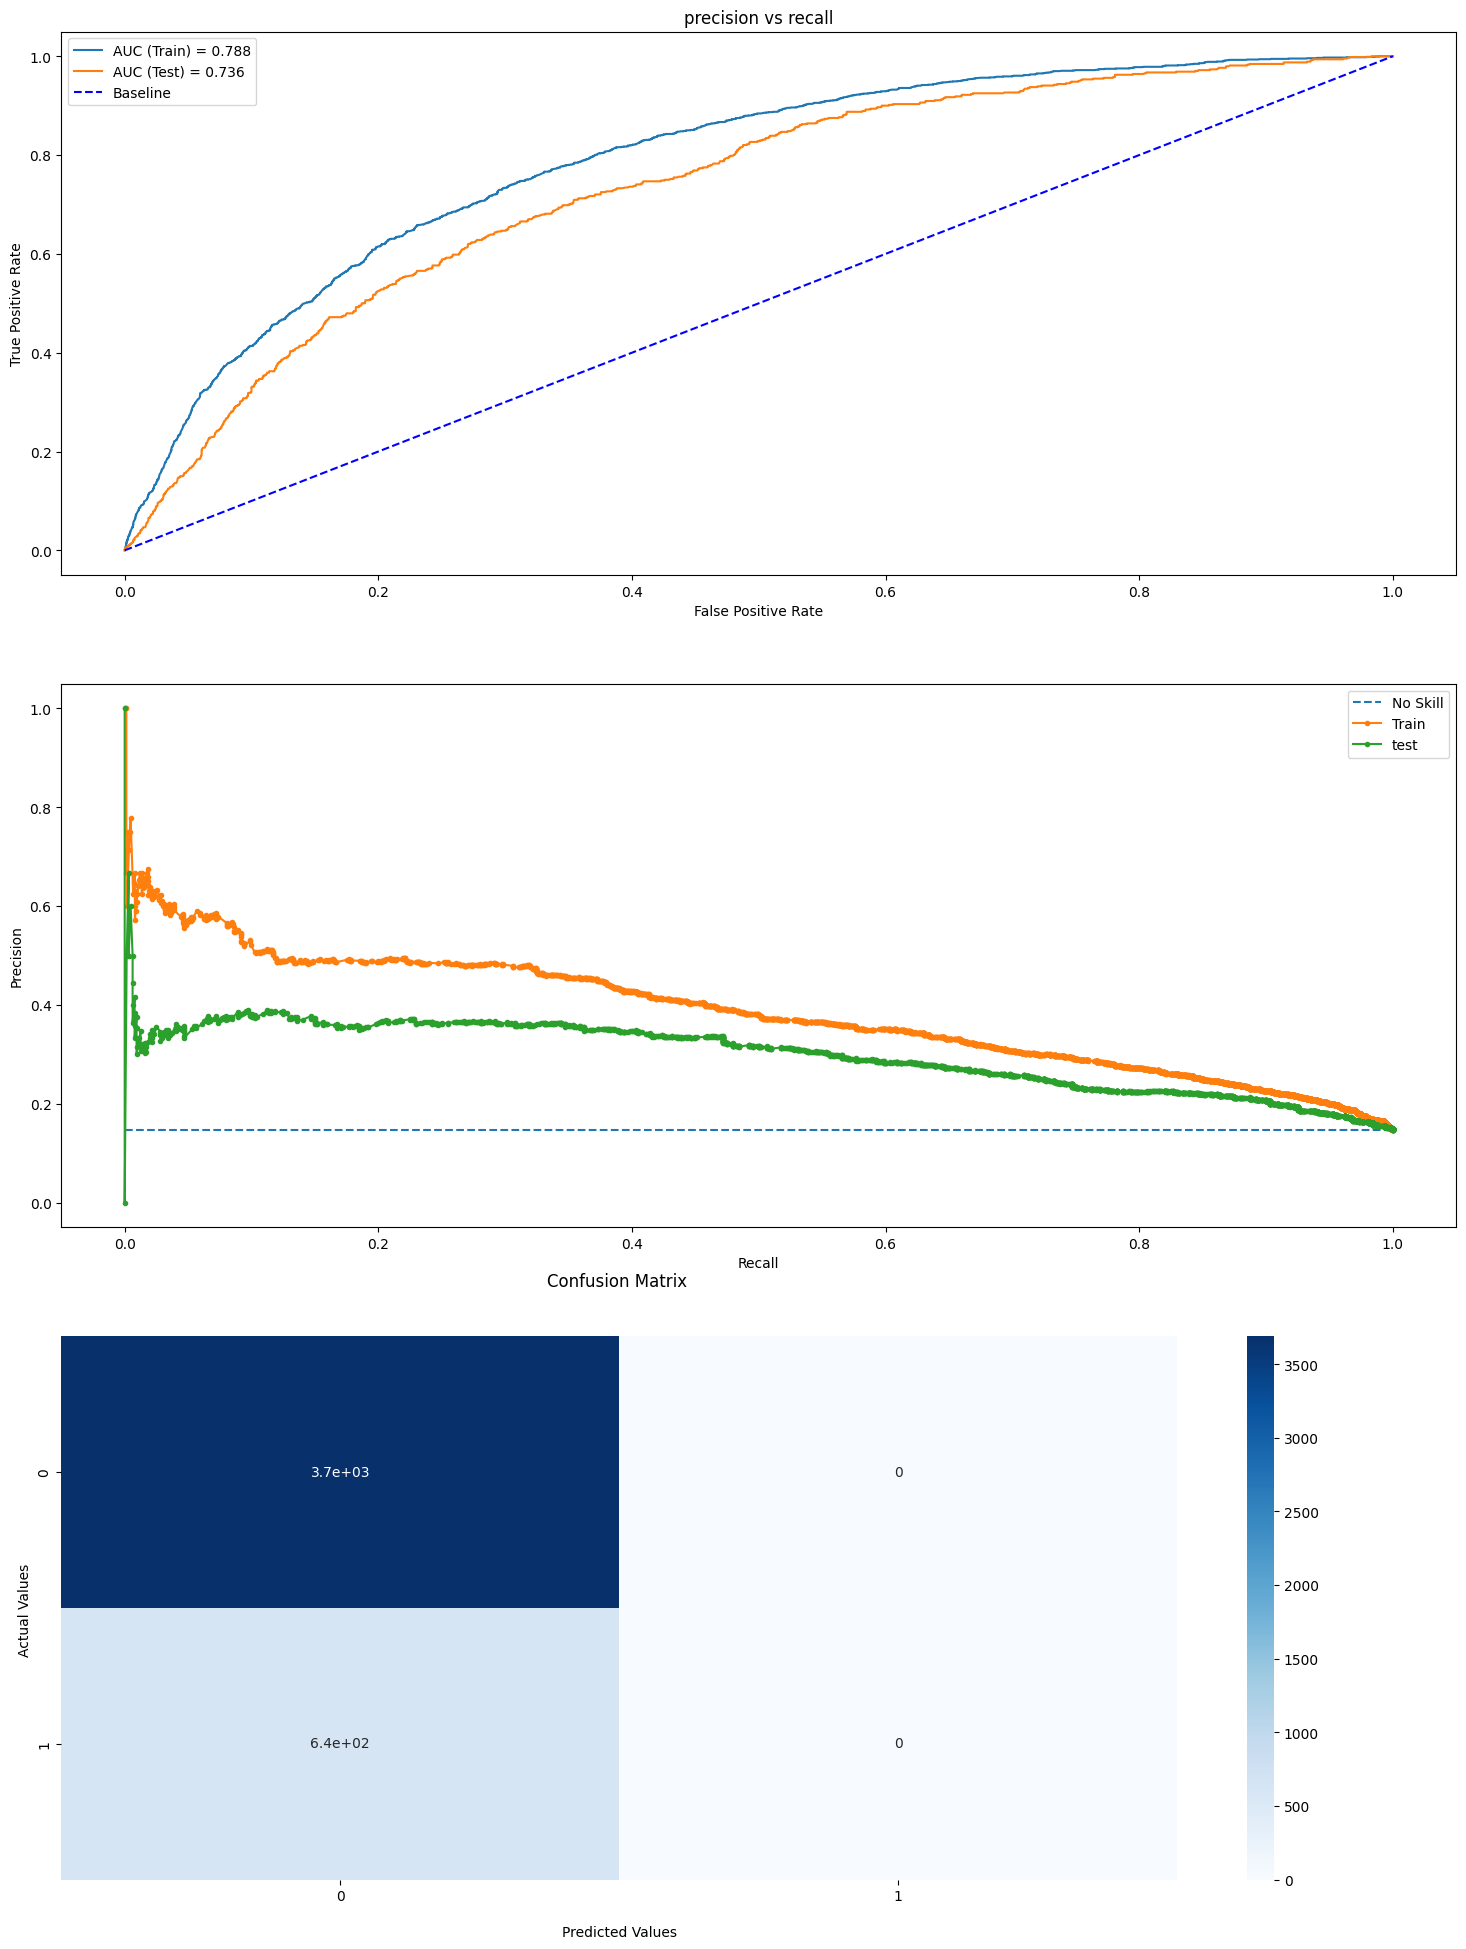

In [281]:
fig, (ax1, ax2,ax3) = plt.subplots(3, 1,figsize=(18,24))

auc_train = roc_auc_score(y_train,X_train['pred_proba'])
fpr_train, tpr_train, thresholds_train = roc_curve(y_train,X_train['pred_proba'])
precision_train, recall_train, thresholds_train = precision_recall_curve(y_train,X_train['pred_proba'])

fpr_df3, tpr_df3, thresholds_df3 = roc_curve(y_test, X_test['pred_proba'])

y_pred = (X_test['pred_proba'] > thresholds[np.argmax(f1_scores)]).astype('float')
cf_matrix=confusion_matrix(y_test, y_pred)

ax1.plot(fpr_train, tpr_train, label=f'AUC (Train) = {auc_train:.3f}')
ax1.plot(fpr_df3, tpr_df3, label=f'AUC (Test) = {auc_score:.3f}')
ax1.plot([0, 1], [0, 1], color='blue', linestyle='--', label='Baseline')
ax1.set_title('ROC Curve', size=12)
ax1.set_xlabel('False Positive Rate', size=10)
ax1.set_ylabel('True Positive Rate', size=10)
ax1.legend()


no_skill = len(y_test[y_test==1]) / len(y_test)
ax2.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
ax2.plot(recall_train, precision_train, marker='.', label='Train')
ax2.plot(recall, precision, marker='.', label='test')
ax1.set_title('precision vs recall', size=12)
ax2.set_xlabel('Recall', size=10)
ax2.set_ylabel('Precision', size=10)
ax2.legend()

ax3 = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax3.set_title('Confusion Matrix \n\n')
ax3.set_xlabel('\nPredicted Values')
ax3.set_ylabel('Actual Values ')

ax3.xaxis.set_ticklabels([0,1])
ax3.yaxis.set_ticklabels([0,1])

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

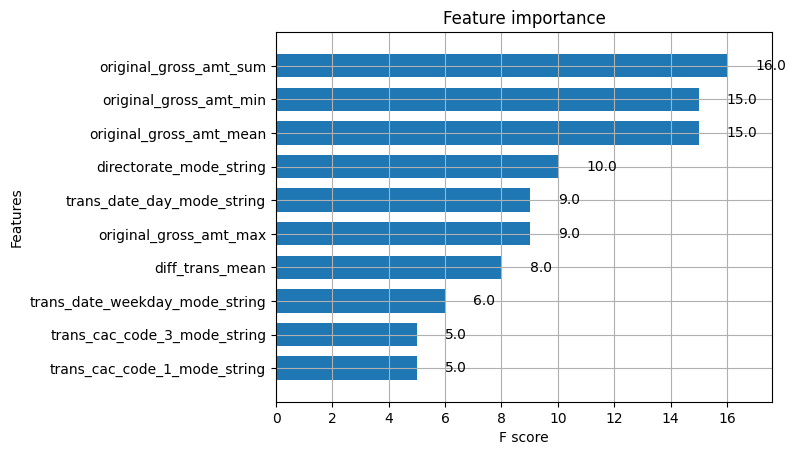

In [282]:
xgb.plot_importance(model, max_num_features=10, height=0.7)

##### Cross validation

In [283]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=2)
auc_stratified_train=[]
auc_stratified_test=[]
f1_score_test=[]
precision_test=[]
recall_test=[]
thresholds_test=[]

for train_index, test_index in skf.split(df_train.drop(columns=[y]), df_train[y]):
    x_train_fold, x_test_fold = df_train.iloc[train_index][columns_to_train], df_train.iloc[test_index][columns_to_train]
    y_train_fold, y_test_fold = df_train.iloc[train_index][y], df_train.iloc[test_index][y]
    encoder = FrequencyEncoder(cols=categoricals_to_index)
    encoder.fit(x_train_fold, y_train_fold)
    x_train_fold=encoder.transform(x_train_fold)
    x_test_fold = encoder.transform(x_test_fold)
    params = {
                  'objective':'binary:logistic',
                  'max_depth': 4,
                  'alpha': 10,
                  'learning_rate': 1.0,
                  'n_estimators':100,
                  'random_state':42,
                  'eval_metric':'auc'
            }

    clf = xgb.XGBClassifier(**params,use_label_encoder=False)
    clf.fit(x_train_fold, y_train_fold,eval_set=[(x_train_fold, y_train_fold)], 
            early_stopping_rounds=20,verbose=False)
    auc_stratified_train.append(roc_auc_score(y_train_fold, clf.predict_proba(x_train_fold)[:,1]))
    auc_stratified_test.append(roc_auc_score(y_test_fold, clf.predict_proba(x_test_fold)[:,1]))
    precision, recall, thresholds = precision_recall_curve(y_test_fold, clf.predict_proba(x_test_fold)[:,1])
    f1_scores = 2*recall*precision/(recall+precision)
    f1_score_test.append(np.max(f1_scores))
    precision_test.append(precision[np.argmax(f1_scores)])
    recall_test.append(recall[np.argmax(f1_scores)])
    thresholds_test.append(thresholds[np.argmax(f1_scores)])


print('\nOverall AUC train:',
      np.mean(auc_stratified_train)*100)
print('\nOverall AUC test:',
      np.mean(auc_stratified_test)*100)
print('\nStandard Deviation in train is:', np.std(auc_stratified_train))
print('\nStandard Deviation in test is:', np.std(auc_stratified_test))
print('\nOverall F1 Score test:',
      np.mean(f1_score_test)*100)
print('\nOverall Precision test:',
      np.mean(precision_test)*100)
print('\nOverall Recall test:',
      np.mean(recall_test)*100)
print('\nOverall thresholds test:',
      np.mean(thresholds_test)*100)
metrics=metrics._append({'Model':'XGBoost',
                'Encoding':'Frequency',
                'Balancing':'Ninguno',
                'AUC':np.mean(auc_stratified_test),
                'F1_score':np.mean(f1_score_test),
                'Precision':np.mean(precision_test),
                'Recall':np.mean(recall_test),
                'threshold':np.mean(thresholds_test),
                'flag_cv':1},
                ignore_index = True)


Overall AUC train: 88.10955173267102

Overall AUC test: 73.29459746647207

Standard Deviation in train is: 0.007196921015222811

Standard Deviation in test is: 0.005479443135864901

Overall F1 Score test: nan

Overall Precision test: 23.5955914852276

Overall Recall test: 44.70802959835516

Overall thresholds test: 30.48684000968933


### Lightgbm

#### target encoding

In [284]:
X_train, X_test, y_train, y_test = train_test_split(df_train[columns_to_train], df_train[y], 
                                                    test_size=0.3, random_state=42,
                                                    stratify=df_train[y])

In [285]:
encoder = TargetEncoder(cols=categoricals_to_index)
encoder.fit(X_train, y_train)
X_train = encoder.transform(X_train)
X_test = encoder.transform(X_test)

In [286]:
params = {
    "objective": "binary",
    "metric": "auc",
    "first_metric_only": True,
    "bagging_fraction": 0.9,
    "feature_fraction": 0.4,
    "lambda_l1": 30,
    "lambda_l2": 90,
    "learning_rate": 0.1517,
    "max_depth": 12,
    "num_leaves": 143,
    "is_unbalance": True,
}

In [287]:
train_data = lgb.Dataset(
                X_train[columns_to_train],
                label=y_train,
                categorical_feature=categoricals_to_index,
                free_raw_data=False,
            )
test_data = lgb.Dataset(
    X_test[columns_to_train],
    label=y_test,
    categorical_feature=categoricals_to_index,
    free_raw_data=False,
)
eval_results = {}
model=lgb.train(
                params,
                train_data,
                num_boost_round=50,
                valid_sets=[test_data],  # [train_data, test_data]
                #feval=self.eval_metrics,
                early_stopping_rounds=10,
                verbose_eval=0,
                evals_result=eval_results,
                # callbacks=[
                #     LightGBMPruningCallback(
                #         trial, self.eval_metrics[0].get_metric_name()
                #     )
                # ],
            )

#X_train['pred_label']=model.predict(X_train[columns_to_train])
X_train['pred_proba']=model.predict(X_train[columns_to_train])
#X_test['pred_label']=model.predict(X_test[columns_to_train])
X_test['pred_proba']=model.predict(X_test[columns_to_train])
auc_score=roc_auc_score(y_test, X_test['pred_proba'])
precision, recall, thresholds = precision_recall_curve(y_test, X_test['pred_proba'])
f1_scores = 2*recall*precision/(recall+precision)
print('AUC: ',auc_score)
print('Best threshold: ', thresholds[np.argmax(f1_scores)])
print('Best F1-Score: ', np.max(f1_scores))
print('Best Recall: ', recall[np.argmax(f1_scores)])
print('Best precision: ', precision[np.argmax(f1_scores)])
metrics=metrics._append({'Model':'Lightgbm',
                'Encoding':'Target',
                'Balancing':'Hyperparameter',
                'AUC':auc_score,
                'F1_score':np.max(f1_scores),
                'Precision':precision[np.argmax(f1_scores)],
                'Recall':recall[np.argmax(f1_scores)],
                'threshold':thresholds[np.argmax(f1_scores)],
                'flag_cv':0},
                ignore_index = True)

[LightGBM] [Info] Number of positive: 1494, number of negative: 8613
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000392 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 10107, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.147818 -> initscore=-1.751816
[LightGBM] [Info] Start training from score -1.751816
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

In [288]:
valdata=X_test.copy()
valdata['target']=y_test
dfks=ks_table(valdata[['target','pred_proba']],target='target', prob='pred_proba')
dfks.to_csv('outputs/ks/ks_lightgbm.csv')

        min_prob  max_prob  events  nonevents event_rate nonevent_rate  \
Decile                                                                   
1       0.727650  0.760018   146.0      287.0     22.81%         7.77%   
2       0.668545  0.726814   118.0      295.0     18.44%         7.99%   
3       0.559733  0.668524   104.0      350.0     16.25%         9.48%   
4       0.475771  0.559343    78.0      355.0     12.19%         9.62%   
5       0.410141  0.475666    59.0      374.0      9.22%        10.13%   
6       0.347298  0.409886    52.0      381.0      8.12%        10.32%   
7       0.292566  0.346910    24.0      409.0      3.75%        11.08%   
8       0.249680  0.292562    32.0      401.0      5.00%        10.86%   
9       0.208218  0.249634    16.0      417.0      2.50%        11.29%   
10      0.088402  0.208206    11.0      423.0      1.72%        11.46%   

       cum_eventrate cum_noneventrate    KS  
Decile                                       
1             22.81

[Text(0, 0.5, '0'), Text(0, 1.5, '1')]

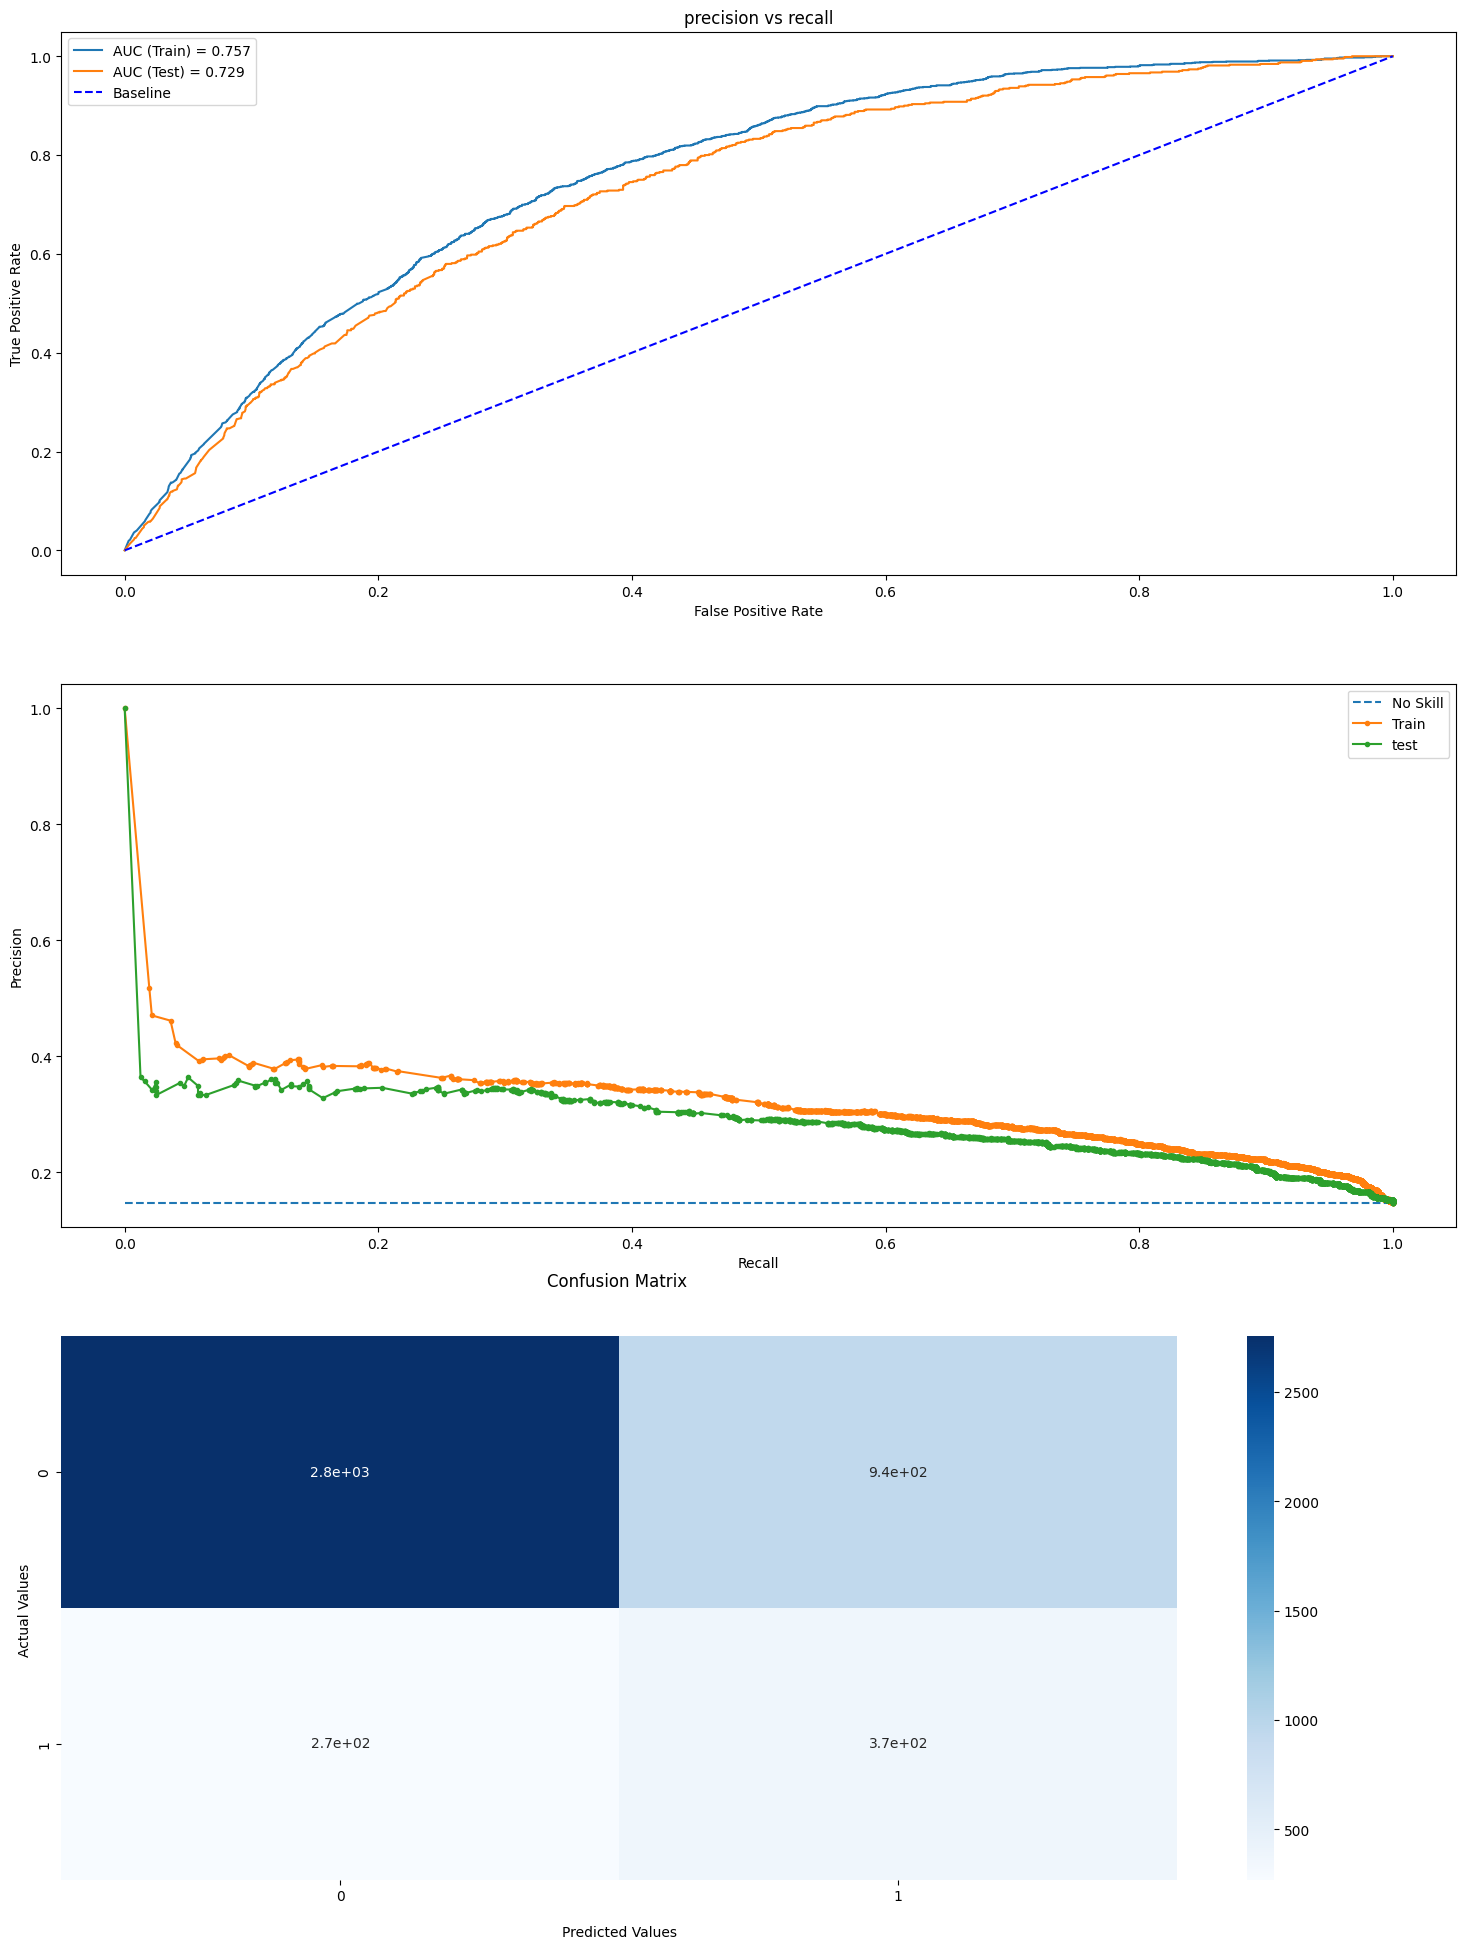

In [289]:
fig, (ax1, ax2,ax3) = plt.subplots(3, 1,figsize=(18,24))

auc_train = roc_auc_score(y_train,X_train['pred_proba'])
fpr_train, tpr_train, thresholds_train = roc_curve(y_train,X_train['pred_proba'])
precision_train, recall_train, thresholds_train = precision_recall_curve(y_train,X_train['pred_proba'])

fpr_df3, tpr_df3, thresholds_df3 = roc_curve(y_test, X_test['pred_proba'])

y_pred = (X_test['pred_proba'] > thresholds[np.argmax(f1_scores)]).astype('float')
cf_matrix=confusion_matrix(y_test, y_pred)

ax1.plot(fpr_train, tpr_train, label=f'AUC (Train) = {auc_train:.3f}')
ax1.plot(fpr_df3, tpr_df3, label=f'AUC (Test) = {auc_score:.3f}')
ax1.plot([0, 1], [0, 1], color='blue', linestyle='--', label='Baseline')
ax1.set_title('ROC Curve', size=12)
ax1.set_xlabel('False Positive Rate', size=10)
ax1.set_ylabel('True Positive Rate', size=10)
ax1.legend()


no_skill = len(y_test[y_test==1]) / len(y_test)
ax2.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
ax2.plot(recall_train, precision_train, marker='.', label='Train')
ax2.plot(recall, precision, marker='.', label='test')
ax1.set_title('precision vs recall', size=12)
ax2.set_xlabel('Recall', size=10)
ax2.set_ylabel('Precision', size=10)
ax2.legend()

ax3 = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax3.set_title('Confusion Matrix \n\n')
ax3.set_xlabel('\nPredicted Values')
ax3.set_ylabel('Actual Values ')

ax3.xaxis.set_ticklabels([0,1])
ax3.yaxis.set_ticklabels([0,1])

In [290]:
feature_importances_lgb = pd.DataFrame (model.feature_importance(), 
                                                index = columns_to_train, 
                                                columns = ['importance'])
feature_importances_lgb.sort_values('importance', ascending = False, inplace = True)
feature_importances_lgb

,importance
original_gross_amt_min,275
diff_trans_mean,200
original_gross_amt_sum,119
original_gross_amt_max,105
original_gross_amt_mean,63
diff_trans_max,35
flag_nan_bill_amt_max,0
trans_date_wom_mode_string,0
trans_date_day_mode_string,0
trans_date_weekday_mode_string,0


##### variable por decil

In [291]:
variables=list(feature_importances_lgb.iloc[:5,0].index)
numericas=list(set(df_train.select_dtypes(exclude='object').columns).intersection(set(variables)))
valdata['grupo'] = pd.cut(valdata.pred_proba,
        bins=[-1, valdata['pred_proba'].quantile(0.1), valdata['pred_proba'].quantile(0.2), valdata['pred_proba'].quantile(0.3),
               valdata['pred_proba'].quantile(0.4), valdata['pred_proba'].quantile(0.5), valdata['pred_proba'].quantile(0.6),
               valdata['pred_proba'].quantile(0.7), valdata['pred_proba'].quantile(0.8), valdata['pred_proba'].quantile(0.9), 1],
        labels=['Decil 10','Decil 9','Decil 8','Decil 7','Decil 6','Decil 5','Decil 4','Decil 3','Decil 2','Decil 1'])

In [ ]:
for var in numericas:
    plt.figure(figsize=(16,10))
    sns.boxplot(x='grupo',y=var,data=valdata, palette='rainbow',order=['Decil 10','Decil 9','Decil 8','Decil 7','Decil 6','Decil 5','Decil 4','Decil 3','Decil 2','Decil 1'])
    plt.show()

In [293]:
file = 'outputs/models/lgbm_target_model.txt'
model.save_model(file)

##### cross validation

In [294]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=2)
auc_stratified_train=[]
auc_stratified_test=[]
f1_score_test=[]
precision_test=[]
recall_test=[]
thresholds_test=[]

for train_index, test_index in skf.split(df_train.drop(columns=[y]), df_train[y]):
    x_train_fold, x_test_fold = df_train.iloc[train_index][columns_to_train], df_train.iloc[test_index][columns_to_train]
    y_train_fold, y_test_fold = df_train.iloc[train_index][y], df_train.iloc[test_index][y]
    encoder = TargetEncoder(cols=categoricals_to_index)
    encoder.fit(x_train_fold, y_train_fold)
    x_train_fold=encoder.transform(x_train_fold)
    x_test_fold = encoder.transform(x_test_fold)
    clf = lgb.LGBMClassifier(**params)
    clf.fit(x_train_fold, y_train_fold,eval_set=[(x_train_fold, y_train_fold)], 
            early_stopping_rounds=20,verbose=False)
    auc_stratified_train.append(roc_auc_score(y_train_fold, clf.predict_proba(x_train_fold)[:,1]))
    auc_stratified_test.append(roc_auc_score(y_test_fold, clf.predict_proba(x_test_fold)[:,1]))
    precision, recall, thresholds = precision_recall_curve(y_test_fold, clf.predict_proba(x_test_fold)[:,1])
    f1_scores = 2*recall*precision/(recall+precision)
    f1_score_test.append(np.max(f1_scores))
    precision_test.append(precision[np.argmax(f1_scores)])
    recall_test.append(recall[np.argmax(f1_scores)])
    thresholds_test.append(thresholds[np.argmax(f1_scores)])


print('\nOverall AUC train:',
      np.mean(auc_stratified_train)*100)
print('\nOverall AUC test:',
      np.mean(auc_stratified_test)*100)
print('\nStandard Deviation in train is:', np.std(auc_stratified_train))
print('\nStandard Deviation in test is:', np.std(auc_stratified_test))
print('\nOverall F1 Score test:',
      np.mean(f1_score_test)*100)
print('\nOverall Precision test:',
      np.mean(precision_test)*100)
print('\nOverall Recall test:',
      np.mean(recall_test)*100)
print('\nOverall thresholds test:',
      np.mean(thresholds_test)*100)
metrics=metrics._append({'Model':'Ligthgbm',
                'Encoding':'Target',
                'Balancing':'Hyperparameter',
                'AUC':np.mean(auc_stratified_test),
                'F1_score':np.mean(f1_score_test),
                'Precision':np.mean(precision_test),
                'Recall':np.mean(recall_test),
                'threshold':np.mean(thresholds_test),
                'flag_cv':1},
                ignore_index = True)

[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] 

#### frequency encoding

In [295]:
X_train, X_test, y_train, y_test = train_test_split(df_train[columns_to_train], df_train[y], 
                                                    test_size=0.3, random_state=42,
                                                    stratify=df_train[y])

In [296]:
encoder = FrequencyEncoder(cols=categoricals_to_index)
encoder.fit(X_train, y_train)
X_train = encoder.transform(X_train)
X_test = encoder.transform(X_test)

In [297]:
params = {
    "objective": "binary",
    "metric": "auc",
    "first_metric_only": True,
    "bagging_fraction": 0.9,
    "feature_fraction": 0.4,
    "lambda_l1": 30,
    "lambda_l2": 90,
    "learning_rate": 0.1517,
    "max_depth": 12,
    "num_leaves": 143,
    "is_unbalance": True,
}

In [298]:
train_data = lgb.Dataset(
                X_train[columns_to_train],
                label=y_train,
                categorical_feature=categoricals_to_index,
                free_raw_data=False,
            )
test_data = lgb.Dataset(
    X_test[columns_to_train],
    label=y_test,
    categorical_feature=categoricals_to_index,
    free_raw_data=False,
)
eval_results = {}
model=lgb.train(
                params,
                train_data,
                num_boost_round=50,
                valid_sets=[test_data],  # [train_data, test_data]
                #feval=self.eval_metrics,
                early_stopping_rounds=10,
                verbose_eval=0,
                evals_result=eval_results,
                # callbacks=[
                #     LightGBMPruningCallback(
                #         trial, self.eval_metrics[0].get_metric_name()
                #     )
                # ],
            )

#X_train['pred_label']=model.predict(X_train[columns_to_train])
X_train['pred_proba']=model.predict(X_train[columns_to_train])
#X_test['pred_label']=model.predict(X_test[columns_to_train])
X_test['pred_proba']=model.predict(X_test[columns_to_train])
auc_score=roc_auc_score(y_test, X_test['pred_proba'])
precision, recall, thresholds = precision_recall_curve(y_test, X_test['pred_proba'])
f1_scores = 2*recall*precision/(recall+precision)
print('AUC: ',auc_score)
print('Best threshold: ', thresholds[np.argmax(f1_scores)])
print('Best F1-Score: ', np.max(f1_scores))
print('Best Recall: ', recall[np.argmax(f1_scores)])
print('Best precision: ', precision[np.argmax(f1_scores)])
metrics=metrics._append({'Model':'Lightgbm',
                'Encoding':'Frequency',
                'Balancing':'Hyperparameter',
                'AUC':auc_score,
                'F1_score':np.max(f1_scores),
                'Precision':precision[np.argmax(f1_scores)],
                'Recall':recall[np.argmax(f1_scores)],
                'threshold':thresholds[np.argmax(f1_scores)],
                'flag_cv':0},
                ignore_index = True)

[LightGBM] [Warning] Met categorical feature which contains sparse values. Consider renumbering to consecutive integers started from zero
[LightGBM] [Warning] Met categorical feature which contains sparse values. Consider renumbering to consecutive integers started from zero
[LightGBM] [Warning] Met categorical feature which contains sparse values. Consider renumbering to consecutive integers started from zero
[LightGBM] [Warning] Met categorical feature which contains sparse values. Consider renumbering to consecutive integers started from zero
[LightGBM] [Warning] Met categorical feature which contains sparse values. Consider renumbering to consecutive integers started from zero
[LightGBM] [Warning] Met categorical feature which contains sparse values. Consider renumbering to consecutive integers started from zero
[LightGBM] [Warning] Met categorical feature which contains sparse values. Consider renumbering to consecutive integers started from zero
[LightGBM] [Warning] Met categoric

[Text(0, 0.5, '0'), Text(0, 1.5, '1')]

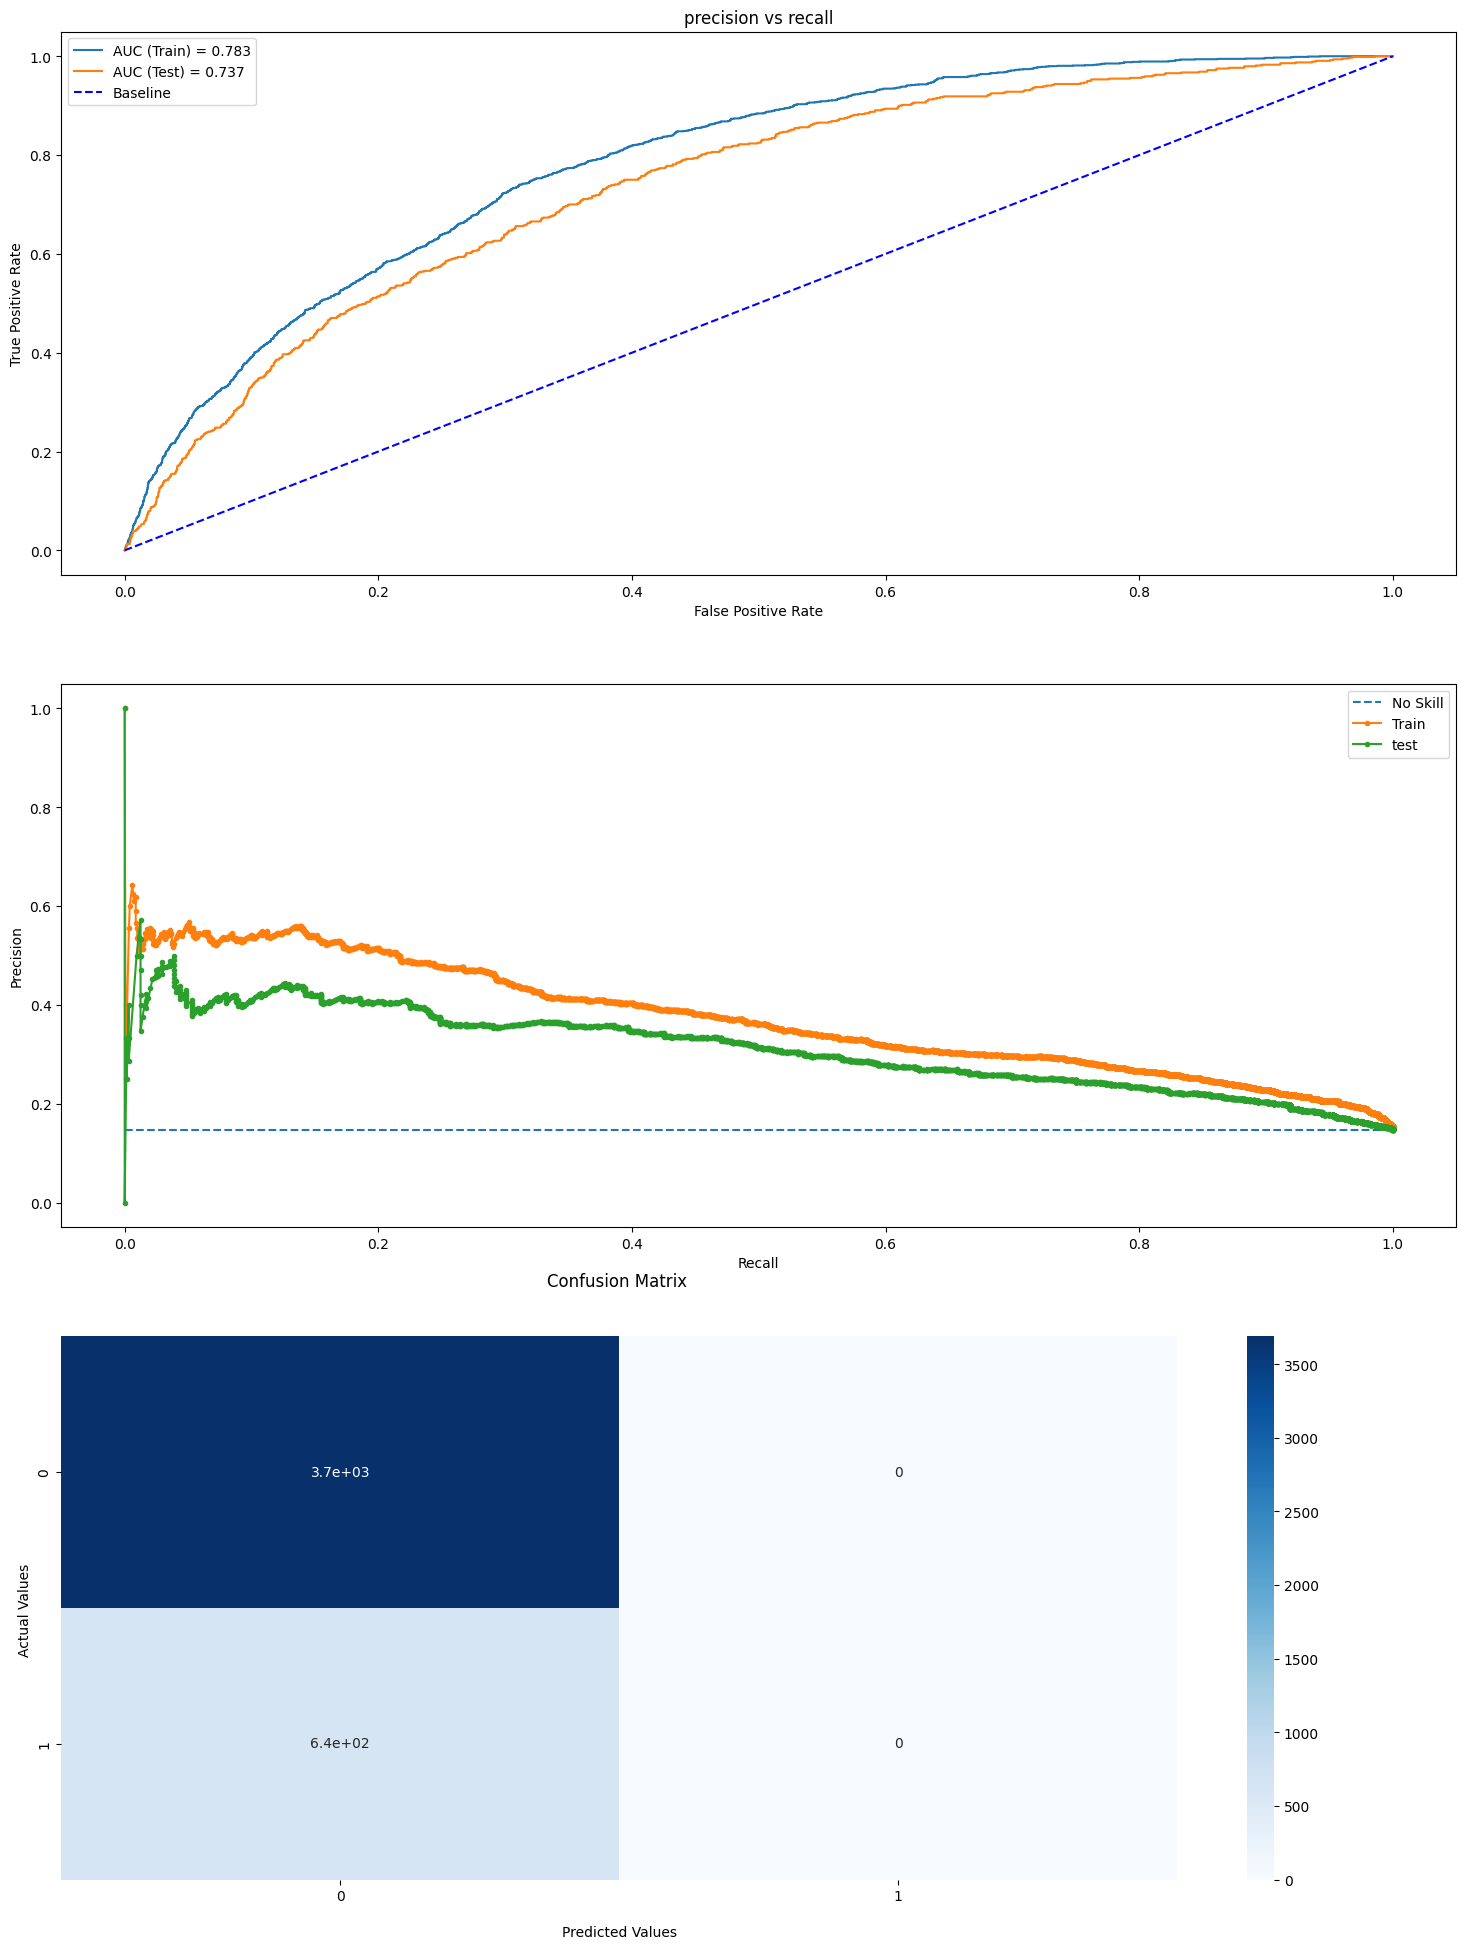

In [299]:
fig, (ax1, ax2,ax3) = plt.subplots(3, 1,figsize=(18,24))

auc_train = roc_auc_score(y_train,X_train['pred_proba'])
fpr_train, tpr_train, thresholds_train = roc_curve(y_train,X_train['pred_proba'])
precision_train, recall_train, thresholds_train = precision_recall_curve(y_train,X_train['pred_proba'])

fpr_df3, tpr_df3, thresholds_df3 = roc_curve(y_test, X_test['pred_proba'])

y_pred = (X_test['pred_proba'] > thresholds[np.argmax(f1_scores)]).astype('float')
cf_matrix=confusion_matrix(y_test, y_pred)

ax1.plot(fpr_train, tpr_train, label=f'AUC (Train) = {auc_train:.3f}')
ax1.plot(fpr_df3, tpr_df3, label=f'AUC (Test) = {auc_score:.3f}')
ax1.plot([0, 1], [0, 1], color='blue', linestyle='--', label='Baseline')
ax1.set_title('ROC Curve', size=12)
ax1.set_xlabel('False Positive Rate', size=10)
ax1.set_ylabel('True Positive Rate', size=10)
ax1.legend()


no_skill = len(y_test[y_test==1]) / len(y_test)
ax2.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
ax2.plot(recall_train, precision_train, marker='.', label='Train')
ax2.plot(recall, precision, marker='.', label='test')
ax1.set_title('precision vs recall', size=12)
ax2.set_xlabel('Recall', size=10)
ax2.set_ylabel('Precision', size=10)
ax2.legend()

ax3 = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax3.set_title('Confusion Matrix \n\n')
ax3.set_xlabel('\nPredicted Values')
ax3.set_ylabel('Actual Values ')

ax3.xaxis.set_ticklabels([0,1])
ax3.yaxis.set_ticklabels([0,1])

In [300]:
feature_importances_lgb = pd.DataFrame (model.feature_importance(), 
                                                index = columns_to_train, 
                                                columns = ['importance'])
feature_importances_lgb.sort_values('importance', ascending = False, inplace = True)
feature_importances_lgb

,importance
original_gross_amt_sum,131
original_gross_amt_min,116
trans_date_day_mode_string,59
original_gross_amt_mean,56
diff_trans_max,45
original_gross_amt_max,35
trans_cac_code_1_mode_string,35
diff_trans_mean,29
directorate_mode_string,17
trans_date_weekday_mode_string,14


##### cross validation

In [302]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=2)
auc_stratified_train=[]
auc_stratified_test=[]
f1_score_test=[]
precision_test=[]
recall_test=[]
thresholds_test=[]

for train_index, test_index in skf.split(df_train.drop(columns=[y]), df_train[y]):
    x_train_fold, x_test_fold = df_train.iloc[train_index][columns_to_train], df_train.iloc[test_index][columns_to_train]
    y_train_fold, y_test_fold = df_train.iloc[train_index][y], df_train.iloc[test_index][y]
    encoder = FrequencyEncoder(cols=categoricals_to_index)
    encoder.fit(x_train_fold, y_train_fold)
    x_train_fold=encoder.transform(x_train_fold)
    x_test_fold = encoder.transform(x_test_fold)
    clf = lgb.LGBMClassifier(**params)
    clf.fit(x_train_fold, y_train_fold,eval_set=[(x_train_fold, y_train_fold)], 
            early_stopping_rounds=20,verbose=False)
    auc_stratified_train.append(roc_auc_score(y_train_fold, clf.predict_proba(x_train_fold)[:,1]))
    auc_stratified_test.append(roc_auc_score(y_test_fold, clf.predict_proba(x_test_fold)[:,1]))
    precision, recall, thresholds = precision_recall_curve(y_test_fold, clf.predict_proba(x_test_fold)[:,1])
    f1_scores = 2*recall*precision/(recall+precision)
    f1_score_test.append(np.max(f1_scores))
    precision_test.append(precision[np.argmax(f1_scores)])
    recall_test.append(recall[np.argmax(f1_scores)])
    thresholds_test.append(thresholds[np.argmax(f1_scores)])


print('\nOverall AUC train:',
      np.mean(auc_stratified_train)*100)
print('\nOverall AUC test:',
      np.mean(auc_stratified_test)*100)
print('\nStandard Deviation in train is:', np.std(auc_stratified_train))
print('\nStandard Deviation in test is:', np.std(auc_stratified_test))
print('\nOverall F1 Score test:',
      np.mean(f1_score_test)*100)
print('\nOverall Precision test:',
      np.mean(precision_test)*100)
print('\nOverall Recall test:',
      np.mean(recall_test)*100)
print('\nOverall thresholds test:',
      np.mean(thresholds_test)*100)
metrics=metrics._append({'Model':'Ligthgbm',
                'Encoding':'Frequency',
                'Balancing':'Hyperparameter',
                'AUC':np.mean(auc_stratified_test),
                'F1_score':np.mean(f1_score_test),
                'Precision':np.mean(precision_test),
                'Recall':np.mean(recall_test),
                'threshold':np.mean(thresholds_test),
                'flag_cv':1},
                ignore_index = True)

[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] 

### benchmarking

In [303]:
metrics.to_csv('outputs/benchmark/metrics.csv',index=False)
metrics

,Model,Encoding,Balancing,AUC,F1_score,Precision,Recall,threshold,flag_cv
0,Logistic,Target,Ninguna,0.713861,0.379786,0.282032,0.581250,0.189999,0
1,Logistic,Target,Ninguna,0.713208,NaN,0.096380,0.192218,0.435576,1
2,Random Forest,Target,Hyperparemeter,0.745804,0.399033,0.325444,0.515625,0.427103,0
3,Random Forest,Target,Hyperparameter,0.740094,NaN,0.183182,0.350820,0.578911,1
4,Random Forest,Frequency,Hyperparemeter,0.745342,NaN,0.000000,0.000000,0.820058,0
5,Random Forest,Frequency,Hyperparameter,0.743100,NaN,0.190089,0.361440,0.640826,1
6,XGBoost,Target,Ninguno,0.718328,NaN,0.000000,0.000000,0.753815,0
7,XGBoost,Target,Ninguno,0.725836,NaN,0.000000,0.000000,0.776450,1
8,XGBoost,Frequency,Ninguno,0.735529,NaN,0.000000,0.000000,0.730258,0
9,XGBoost,Frequency,Ninguno,0.732946,NaN,0.235956,0.447080,0.304868,1


## Test

In [318]:
target=df_test[y]
id_col=df_test[id]
df_test.drop(columns=y,inplace=True)
with open("outputs/encoders/target_encoder.pkl", "rb") as input_file:
    encoder = pickle.load(input_file)
df_test = encoder.transform(df_test[columns_to_train])
df_test[y]=target
df_test[id]=id_col

### XGboost predict

In [319]:
model= xgb.Booster()
model.load_model("outputs/models/xgboost_target_model.json")

In [320]:
dtest = xgb.DMatrix(df_test[columns_to_train])

In [321]:
df_test['pred_proba']=model.predict(dtest)

In [322]:
df_test[[id,y,'pred_proba']].to_csv('data/out/order_predictions_xgboost.csv',index=False)

In [323]:
auc_score=roc_auc_score(df_test[y], df_test['pred_proba'])
precision, recall, thresholds = precision_recall_curve(df_test[y], df_test['pred_proba'])
f1_scores = 2*recall*precision/(recall+precision)
print('AUC: ',auc_score)
print('Best threshold: ', thresholds[np.argmax(f1_scores)])
print('Best F1-Score: ', np.max(f1_scores))
print('Best Recall: ', recall[np.argmax(f1_scores)])
print('Best precision: ', precision[np.argmax(f1_scores)])

AUC:  0.7267581328594861
Best threshold:  0.5743116
Best F1-Score:  nan
Best Recall:  0.0
Best precision:  0.0


### Lightgbm predict

In [325]:
model = lgb.Booster(model_file="outputs/models/lgbm_target_model.txt")
df_test['pred_proba']=model.predict(df_test[columns_to_train])

In [326]:
df_test[[id,y,'pred_proba']].to_csv('data/out/order_predictions_lgbm.csv',index=False)

In [327]:
auc_score=roc_auc_score(df_test[y], df_test['pred_proba'])
precision, recall, thresholds = precision_recall_curve(df_test[y], df_test['pred_proba'])
f1_scores = 2*recall*precision/(recall+precision)
print('AUC: ',auc_score)
print('Best threshold: ', thresholds[np.argmax(f1_scores)])
print('Best F1-Score: ', np.max(f1_scores))
print('Best Recall: ', recall[np.argmax(f1_scores)])
print('Best precision: ', precision[np.argmax(f1_scores)])

AUC:  0.7414804310187717
Best threshold:  0.6392054276655783
Best F1-Score:  0.3836734693877551
Best Recall:  0.5310734463276836
Best precision:  0.3003194888178914


### Logistic predict

In [328]:
scaler = StandardScaler()
df_test[columns_to_train]=scaler.fit_transform(df_test[columns_to_train])

In [329]:
lr = pickle.load(open("outputs/models/lr_target_model.sav", 'rb'))
df_test['pred_proba']=lr.predict_proba(df_test[columns_to_train])[:,1]

In [330]:
df_test[[id,y,'pred_proba']].to_csv('data/out/order_predictions_lr.csv',index=False)

In [331]:
auc_score=roc_auc_score(df_test[y], df_test['pred_proba'])
precision, recall, thresholds = precision_recall_curve(df_test[y], df_test['pred_proba'])
f1_scores = 2*recall*precision/(recall+precision)
print('AUC: ',auc_score)
print('Best threshold: ', thresholds[np.argmax(f1_scores)])
print('Best F1-Score: ', np.max(f1_scores))
print('Best Recall: ', recall[np.argmax(f1_scores)])
print('Best precision: ', precision[np.argmax(f1_scores)])

AUC:  0.7129852378348825
Best threshold:  0.22197796733731717
Best F1-Score:  0.35020242914979766
Best Recall:  0.4887005649717514
Best precision:  0.27287066246056785


## variable explanation

### shap

#### xgboost

In [332]:
model= xgb.Booster()
model.load_model("outputs/models/xgboost_target_model.json")

In [335]:
# DF, based on which importance is checked
X_importance = encoder.transform(df_train[columns_to_train])

# Explain model predictions using shap library:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_importance)

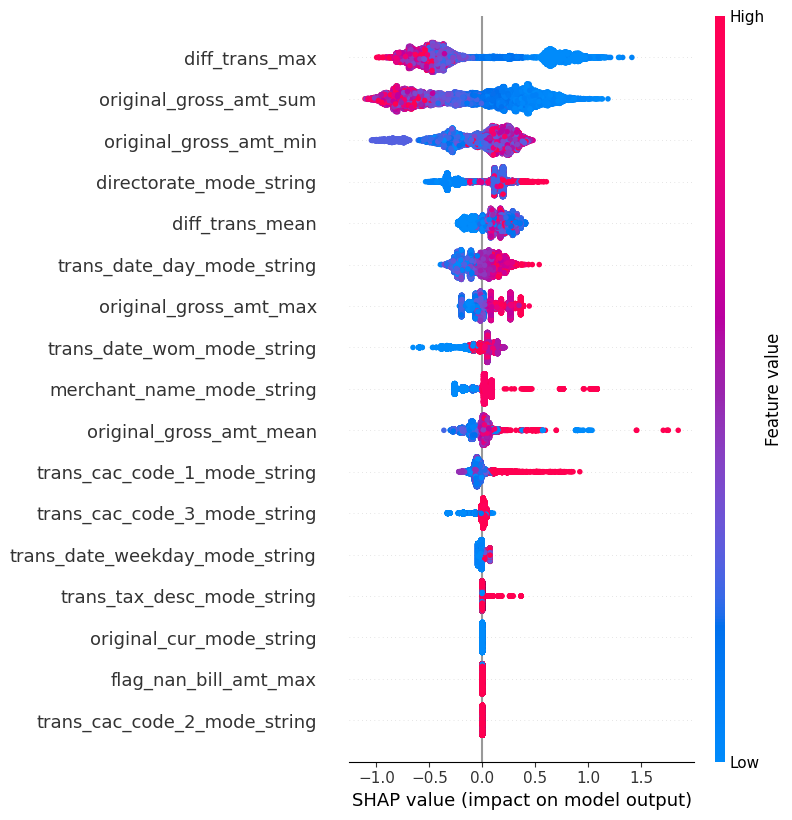

In [336]:
# Plot summary_plot
shap.summary_plot(shap_values, X_importance)

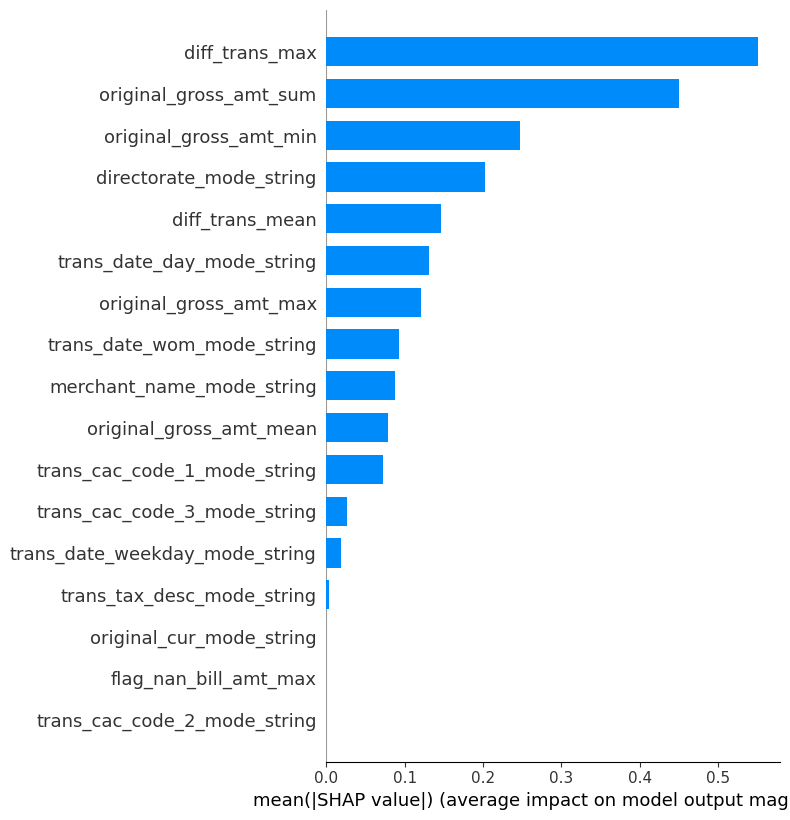

In [337]:
shap.summary_plot(shap_values, X_importance, plot_type='bar')

In [338]:
shap_interaction_values = shap.TreeExplainer(model).shap_interaction_values(X_importance)

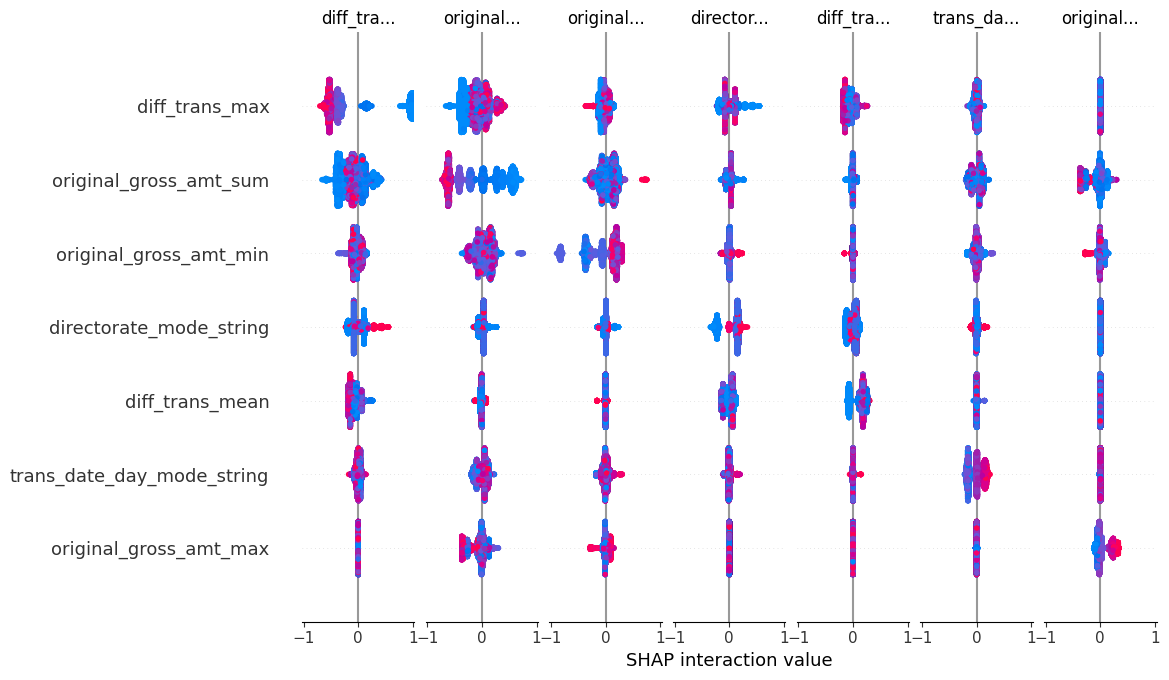

In [339]:
shap.summary_plot(shap_interaction_values, X_importance)

#### lightgbm

In [340]:
model = lgb.Booster(model_file="outputs/models/lgbm_target_model.txt")
model.params['objective'] = 'binary'

In [341]:
# DF, based on which importance is checked
X_importance = encoder.transform(df_train[columns_to_train])

# Explain model predictions using shap library:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_importance)

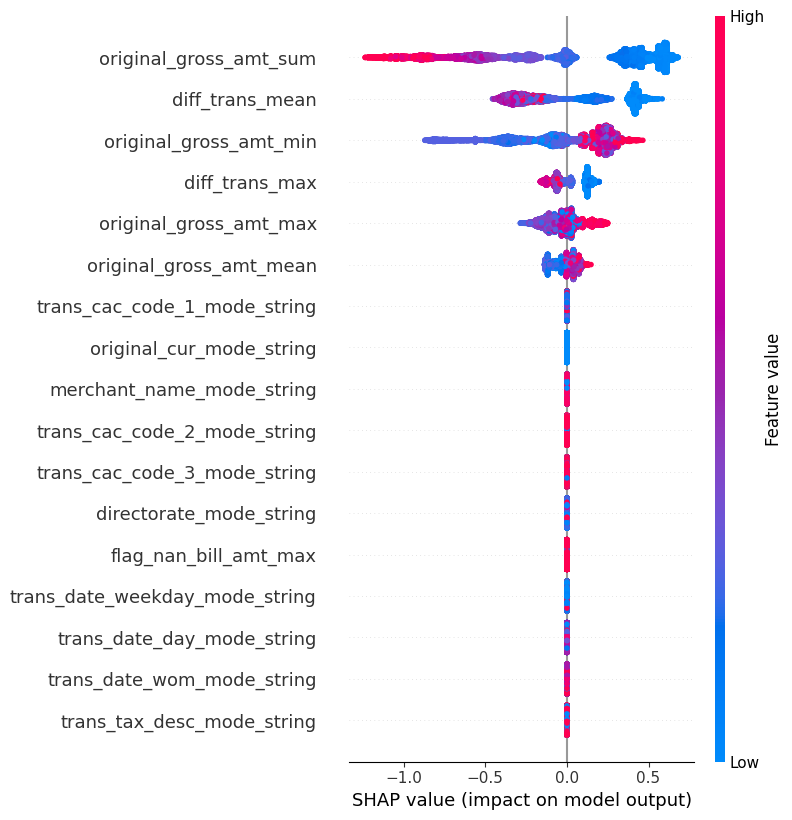

In [342]:
# Plot summary_plot
shap.summary_plot(shap_values[1], X_importance,plot_type="dot")

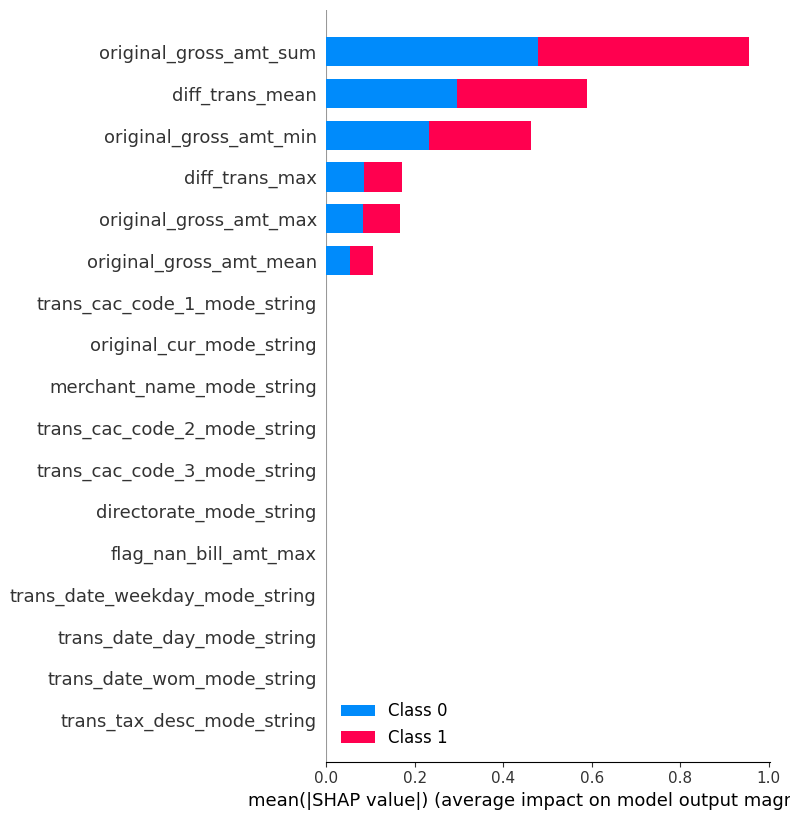

In [343]:
shap.summary_plot(shap_values, X_importance, plot_type='bar')

In [344]:
shap_interaction_values = shap.TreeExplainer(model).shap_interaction_values(X_importance)

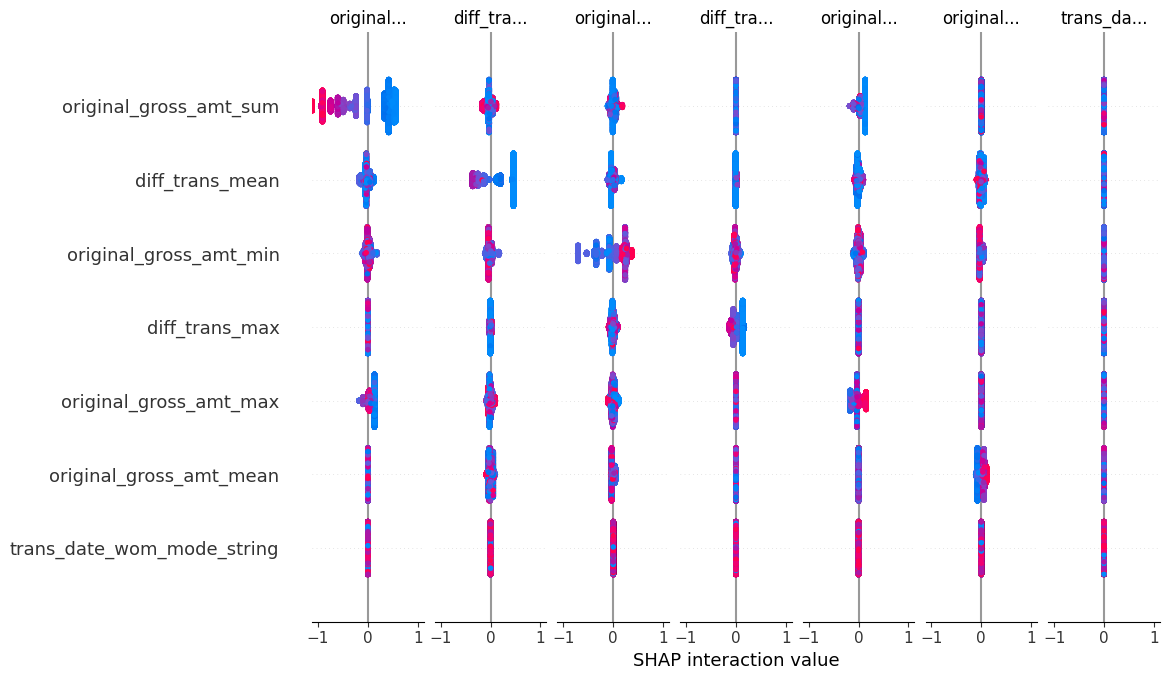

In [345]:
shap.summary_plot(shap_interaction_values, X_importance)

#### logistic

In [346]:
lr = pickle.load(open("outputs/models/lr_target_model.sav", 'rb'))
# DF, based on which importance is checked
X_importance = encoder.transform(df_train[columns_to_train])

scaler = StandardScaler()
X_importance[columns_to_train]=scaler.fit_transform(X_importance[columns_to_train])

# Explain model predictions using shap library:
explainer = shap.LinearExplainer(lr,X_importance)
shap_values = explainer.shap_values(X_importance)

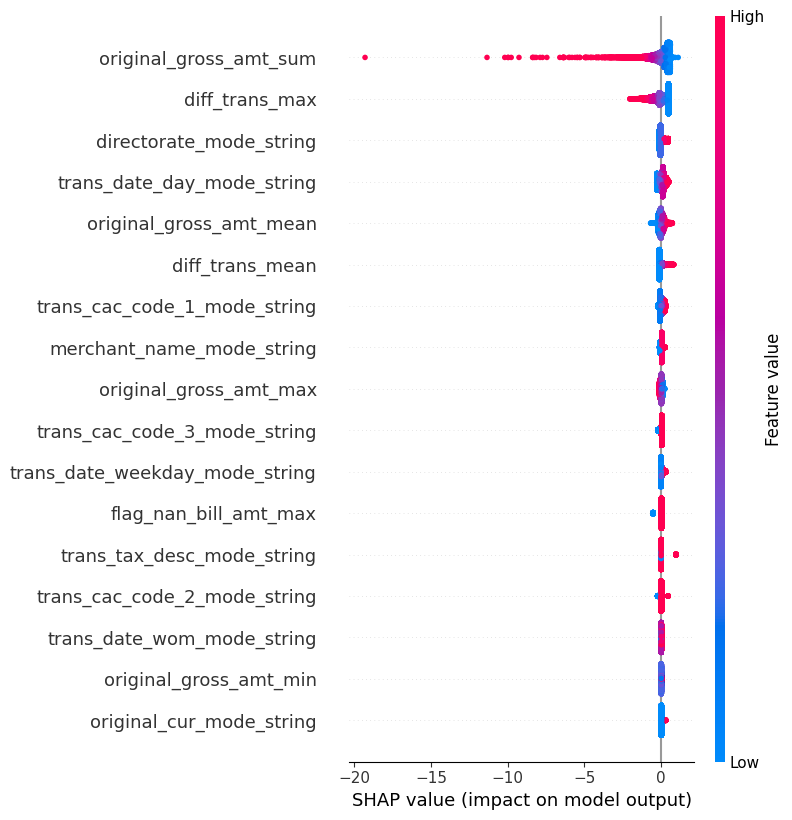

In [347]:
# Plot summary_plot
shap.summary_plot(shap_values, X_importance,plot_type="dot")

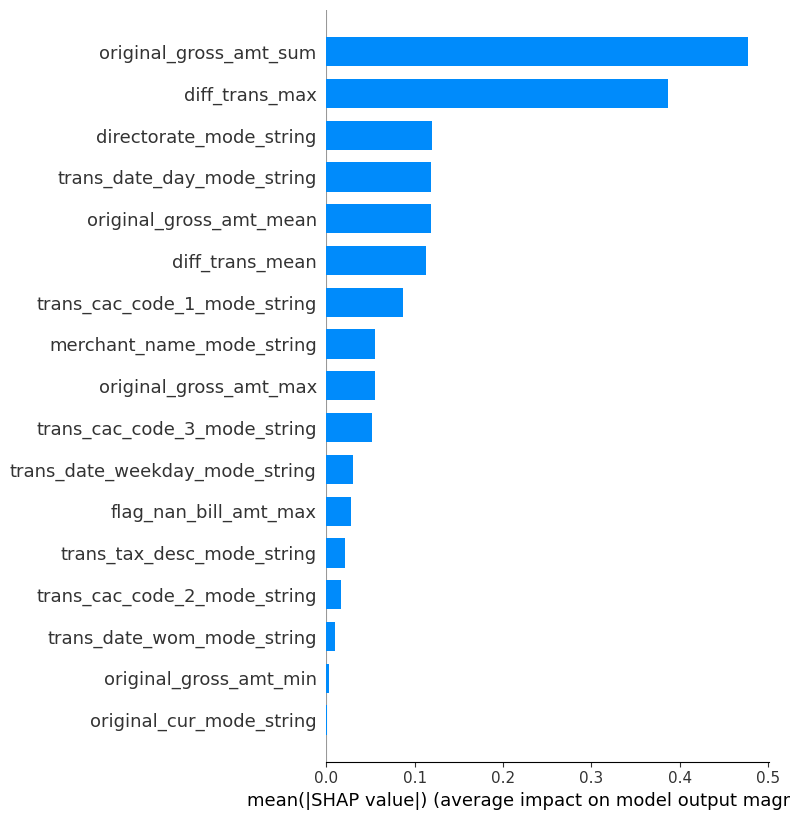

In [348]:
shap.summary_plot(shap_values, X_importance, plot_type='bar')

# Deployment

## 1-How could you deploy this model for a production setting?

To deploy the model for a production setting, several steps need to be followed. First, ensure that the model and associated code are properly version-controlled using a version control system such as Git. Next, containerize the Flask API using Docker, which allows for easy deployment and scaling. Create a Dockerfile to define the environment and dependencies needed to run the Flask API. Once the Docker image is built, it can be deployed to a container orchestration platform like Kubernetes or a cloud provider's container service. These platforms enable scalability, load balancing, and automated management of the containers. Utilize a cloud-based service or infrastructure for high availability, fault tolerance, and easy scaling. Implement appropriate security measures such as encryption, authentication, and access control to protect the deployed API. Monitor the API's performance, logs, and errors using logging and monitoring tools. Continuously test and validate the API using automated testing frameworks to ensure accuracy and reliability. Regularly update and maintain the deployed model and codebase to incorporate bug fixes, improvements, and new features.

## 2- How do you scale your application with the model? 

To scale the application with the model, you can employ various strategies. One approach is horizontal scaling, where multiple instances of the application are deployed to handle increased traffic and workload. Load balancers can distribute incoming requests across these instances to ensure optimal resource utilization and prevent overload. Additionally, you can utilize a message queue or task queue system to handle the processing of requests asynchronously, allowing the application to handle more concurrent requests. This can be especially useful if there are resource-intensive tasks involved in the prediction process. Furthermore, you can leverage caching mechanisms to store and serve frequently accessed data, reducing the computational load on the application. Scaling the infrastructure hosting the application, such as using auto-scaling groups in cloud platforms, can also help accommodate varying demand. Continuous monitoring and performance optimization are crucial to identify potential bottlenecks and ensure efficient resource allocation. By employing these scaling strategies, the application can handle higher volumes of traffic and provide a responsive and reliable user experience.

## 3- How do you do performance testing for your API?

Performance testing for the API of the model involves evaluating its responsiveness, scalability, and stability under various workloads. To conduct performance testing, you can use tools like Apache JMeter, Locust, or Gatling. First, define realistic test scenarios that simulate expected user behavior and workload patterns. These scenarios can include different types of requests, varying data volumes, and concurrent user loads. Execute the performance tests and measure key metrics such as response time, throughput, error rate, and resource utilization. Analyze the results to identify potential performance bottlenecks, such as slow API endpoints or high resource consumption. Adjust the infrastructure, code, or configuration accordingly to optimize performance. Repeat the performance tests after making optimizations to validate the improvements. It's important to perform both **load testing**, where the system is tested under expected loads, and **stress testing**, where the system is pushed beyond its limits to identify failure points. By conducting performance testing, you can ensure that the API of the model meets the required performance criteria and can handle the expected workload effectively.